# Algorithm Theoretical Basis Document: Algorithms to Validate NISAR L2 Coseismic, Transient and Secular Displacement Requirements

*Revision 14*

*January 31, 2021*

*NISAR Solid Earth Team*

In [1]:
# Choose a site and track direction
site='RidgecrestA64'  # 2019 Ridgecrest Earthquakes in California ascending track 64
# site='RidgecrestD71'  # 2019 Ridgecrest Earthquakes in California descending track 71

<hr/>

# Workflow to Validate NISAR L2 Coseismic Displacement Requirement

**Original code authored by:** David Bekaert, Heresh Fattahi, Eric Fielding, and Zhang Yunjun 

Extensive modifications by Adrian Borsa and Amy Whetter 2022

<div class="alert alert-warning">
Both the initial setup (<b>Prep A</b> section) and download of the data (<b>Prep B</b> section) should be run at the start of the notebook. And all subsequent sections NEED to be run in order.
</div>

<hr/>

## Table of Contents:
<a id='example_TOC'></a>

<hr/>

[**Prep. Stack Preparation**](#prep_stack)
- [Prep A. Configure Local Processing Environment](#prep_a)
- [Prep B. Download (ARIA) Interferograms from ASF](#prep_b)

[**1. Generate Interferogram Stack**](#gen_ifg)
- [1.A  Crop Interferograms](#crop_ifg)

[**2. Generation of Time Series from Interferograms**](#gen_ts)
- [2.A Set Up MintPy Configuration file](#setup_config)
- [2.B Load Data into MintPy](#load_data)
- [2.C Validate/Modify Interferogram Network](#validate_network)
- [2.D Generate Quality Control Mask](#generate_mask)
- [2.E Reference Interferograms To Common Lat/Lon](#common_latlon)
- [2.F Invert for SBAS Line-of-Sight Timeseries](#invert_SBAS)

[**3. Optional Corrections**](#opt_correction)
- [3.A Solid Earth Tides Correction](#solid_earth)
- [3.B Tropospheric Delay Correction](#tropo_corr)
- [3.C Phase Deramping ](#phase_deramp)
- [3.D Topographic Residual Correction ](#topo_corr) 

[**4. Decomposition of InSAR and GNSS Time Series Into Basis Functions**](#decomp_ts)
- [4.A Estimate InSAR LOS Velocities](#estimate_vel)
    - [4.A.1 Estimate InSAR Coseismic Displacement](#estimate_vel_cos)
- [4.B Find Collocated GNSS Stations](#find_gnss)
- [4.C Get GNSS Position Time Series](#get_gnss)
- [4.D Make GNSS LOS Velocities](#make_gnss)
- [4.E Re-reference GNSS and InSAR Velocities](#reref_gnss)

[**5. NISAR Validation: GNSS-InSAR Direct Comparison Using Time-series Displacement Fit**](#nisar_validation)
- [5.A Make Velocity Residuals at GNSS Locations](#make_vel)
- [5.B Make Double-differenced Velocity Residuals](#make_velres)
- [5.C Compare Raw Velocities](#compare_raw)
- [5.D Plot Velocity Residuals](#plot_vel)
- [5.E Plot Double-differenced Residuals](#plot_velres)
- [5.F Amplitude vs. Distance of Double-differences (not quite a structure function)](#ampvsdist)

[**6. NISAR Validation: InSAR Residuals Analysis**](#nisar_anal)
- [6.A Make Double-differenced Velocity Residuals](#make_velres2)
- [6.B Amplitude vs. Distance of Double-differences (not quite a structure function)](#ampvsdist2)

[**Appendix: GPS Position Plots**](#appendix_gps)

<hr/>

# Prep. Stack Preparation
<a id='prep_stack'></a>
In this initial processing step, all the necessary Level-2 unwrapped interferogram products are gathered, organized and reduced to a common grid for analysis with MintPy. Ascending and descending stacks of nearest-neighbor and skip-1 interferograms will be prepared for independent analysis. 

## Prep A. Configure Local Processing Environment
<a id='prep_a'></a>

In [2]:
# option to control the use of pre-staged data; [False/True]
Use_Staged_Data = False

# ------------------------------------------------------------------------------------------- #
# no changed below needed:

#Load Packages
import math
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
import pylab
import zipfile
from datetime import datetime as dt
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
from matplotlib import pyplot as plt
from mintpy.utils import readfile, utils as ut
from mintpy.objects import gps
from mintpy.objects.gps import GPS
from scipy import signal
from scipy import special
from scipy.stats import binned_statistic
from pathlib import Path
import subprocess
import pyproj
from solid_utils import variogram
import requests

# helpful check routine
def is_downloadable(url):
    """
    Does the url contain a downloadable resource
    """
    h = requests.head(url, allow_redirects=True)
    header = h.headers
    content_type = header.get('content-type')
    if 'text' in content_type.lower():
        return False
    if 'html' in content_type.lower():
        return False
    return True

In [3]:
#Set Custom Parameters

# top-level directory for calval work
input_dir = os.getcwd()
# magic path object
input_dir_obj = os.path.join(input_dir, 'calval')

# set some defaults for site parameters 
ifgExcludeList = 'auto'  # default is not to exclude any interferograms
tempBaseMax = 'auto'  # dedfult to use all temporal baselines
maskWater = False  # interior locations don't need to mask water

if site == 'CV':    # use Central Valley test site
    calval_location = 'central_valley'
    download_region = '"36.18 36.26 -119.91 -119.77"' #download box in S,N,W,E format
    analysis_region = '"35.77 36.75 -120.61 -118.06"' #analysis box in S,N,W,E format (must be within download_region)
    download_start_date = '20180101'
    download_end_date = '20180801'
    earthquakeDate = '20180412'  # arbitrary date for testing with the central_valley dataset
    sentinel_track = '144'
    gps_ref_site_name = 'P467'  # reference site for this area


elif site == 'OK': # use Oklahoma site
    # WKT POLYGON((-103.3517 31.6698,-93.4754 31.6698,-93.4754 37.4283,-103.3517 37.4283,-103.3517 31.6698))    
    calval_location = 'Oklahoma'
    download_region = '"31.7 37.4 -103.3 -93.5"' #download box in S,N,W,E format
    analysis_region = '"35.25 36.5 -100.5 -98.5"' #analysis box in S,N,W,E format (must be within download_region)
    download_start_date = '20210101'
    download_end_date = '20210801'
    earthquakeDate = '20210328'  # arbitrary date for testing with the Oklahoma dataset
    sentinel_track = '107'
    gps_ref_site_name = 'OKCL'

elif site == 'PR': # use Puerto Rico site
    # WKT POLYGON((-108.6123 28.7487,-101.5139 28.7487,-101.5139 34.3766,-108.6123 34.3766,-108.6123 28.7487))    
    calval_location = 'PuertoRicoDesc'
    download_region = '"17.5 18.9 -67.5 -66.0"' #download box in S,N,W,E format
    analysis_region = '"17.9 18.5 -67.3 -66.2"' #analysis box in S,N,W,E format (must be within download_region)
    download_start_date = '20190701'
    download_end_date = '20200930'
    earthquakeDate = '20200107'  #  date of M6.4 quake
    sentinel_track = '98'  # descending track
    gps_ref_site_name = 'PRLT'
    tempBaseMax = 24  # don't use interferograms longer than 24 days
    maskWater = True  # need to mask ocean around Puerto Rico island

elif site == 'PRa': # use Puerto Rico site
    # WKT POLYGON((-108.6123 28.7487,-101.5139 28.7487,-101.5139 34.3766,-108.6123 34.3766,-108.6123 28.7487))    
    calval_location = 'PuertoRicoAsc'
    download_region = '"17.5 18.9 -67.5 -66.0"' #download box in S,N,W,E format
    analysis_region = '"17.9 18.5 -67.3 -66.2"' #analysis box in S,N,W,E format (must be within download_region)
    download_start_date = '20190701'
    download_end_date = '20200930'
    earthquakeDate = '20200107'  #  date of M6.4 quake
    earthquakeDate2 = '20200703' # date of large aftershock
    sentinel_track = '135'  # ascending track
    gps_ref_site_name = 'PRLT'
    tempBaseMax = 24  # don't use interferograms longer than 24 days
    maskWater = True  # need to mask ocean around Puerto Rico island

elif site == 'RidgecrestD71': # Ridgecrest EQ
    calval_location = 'RidgecrestD71'
    download_region = '"34.5 37.5 -119.0 -116.0"' #download box in S,N,W,E format
    analysis_region = '"34.7 37.2 -118.9 -116.1"' #analysis box in S,N,W,E format (must be within download_region)
    download_start_date = '20190601'
    download_end_date = '20190831'
    earthquakeDate = '20190705'  # M7.2 quake date at Ridgecrest
    sentinel_track = '71'
    gps_ref_site_name = 'ISLK'
    
elif site == 'RidgecrestA64': # Ridgecrest EQ
    calval_location = 'Ridgecrest'
    download_region = '"34.5 37.5 -119.0 -116.0"' #download box in S,N,W,E format
    analysis_region = '"34.7 37.2 -118.9 -116.1"' #analysis box in S,N,W,E format (must be within download_region)
    download_start_date = '20190101'
    download_end_date = '20191231'
    earthquakeDate = '20190705'  # M7.2 quake date at Ridgecrest
    sentinel_track = '64'
    ifgExcludeList = '[50,121,123,124,125,126]' # list of bad ifgs to exclude from time-series analysis
    gps_ref_site_name = 'ISLK'

#Set Directories
work_dir = os.path.join(input_dir, calval_location)
print("Work directory: ", work_dir)
print("Earthquake date", earthquakeDate)
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)
mint_dir = os.path.join(work_dir, 'MintPy')
if not os.path.isdir(mint_dir):
    os.makedirs(mint_dir)
gunw_dir = os.path.join(work_dir, 'products')


work_dir_obj = os.path.join(input_dir_obj, calval_location)
mint_dir_obj = os.path.join(work_dir_obj, 'Mintpy')


Work directory:  /home/jovyan/ATBD/methods/coseismicRidgecrest/
Earthquake date 20190705


TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [4]:
#Verify MintPy Installation
try:
    from mintpy import view, tsview, plot_network, plot_transection, plot_coherence_matrix
except ImportError:
    raise ImportError("Looks like mintPy is not fully installed")

#Set Global Plot Parameters
plt.rcParams.update({'font.size': 12})

## Prep B. Download (ARIA) Interferograms from ASF
<a id='prep_b'></a>

In [5]:
# download all interferograms that intersect download_region over specified time range
os.chdir(work_dir)

if not Use_Staged_Data:
    command = 'ariaDownload.py --bbox ' + download_region + ' --start ' + download_start_date + ' --end ' + download_end_date 
    if sentinel_track != '':
        command = command + ' --track ' + sentinel_track
    os.system(command + ' -o Count');
    os.system(command);

    #delete unnecessary files
    if os.path.exists(gunw_dir + "avg_rates.csv"):
      os.remove(gunw_dir + "avg_rates.csv")
    if os.path.exists(gunw_dir + "ASFDataDload0.py"):
      os.remove(gunw_dir + "ASFDataDload0.py")
    if os.path.exists(gunw_dir + "AvgDlSpeed.png"):
      os.remove(gunw_dir + "AvgDlSpeed.png")
    if os.path.exists(gunw_dir + "error.log"):
      os.remove(gunw_dir + "error.log")
    if os.path.exists(work_dir + "error.log"):
      os.remove(work_dir + "error.log")

ARIA-tools Version: 1.1.0

Found -- 387 -- products
ARIA-tools Version: 1.1.0
Wrote -- 387 -- products to: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/products


/Users/fielding/anaconda3/envs/ARIA-tools/lib/python3.8/site-packages/asf_search/download/download.py:61: UserWarning: File already exists, skipping download: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/products/S1-GUNW-A-R-064-tops-20191231_20191207-015130-38870N_36999N-PP-b9c3-v2_0_4.nc
  warnings.warn(f'File already exists, skipping download: {os.path.join(path, filename)}')
/Users/fielding/anaconda3/envs/ARIA-tools/lib/python3.8/site-packages/asf_search/download/download.py:61: UserWarning: File already exists, skipping download: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/products/S1-GUNW-A-R-064-tops-20191231_20191213-015130-38870N_36999N-PP-5c90-v2_0_2.nc
  warnings.warn(f'File already exists, skipping download: {os.path.join(path, filename)}')
/Users/fielding/anaconda3/envs/ARIA-tools/lib/python3.8/site-packages/asf_search/download/download.py:61: UserWarning: File already exists, skipping download: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/products/S1-GUNW-A-R

# 1. Generate Interferogram Stack
<a id='gen_ifg'></a>
The NISAR project will provide sets of fully coregistered ascending and descending unwrapped L2 interferograms (aka InSAR “stacks”) over regions of interest listed in the NISAR Solid Earth calval document. For the purpose of testing calval algorithms prior to NISAR launch, the NISAR SE team will make interferogram stack using SAR data from complementary missions (e.g. Sentinel-1 or ALOS-2). These stacks will include at a minimum nearest-neighbor and skip-1 interferograms to mimic the planned standard L2 data product from NISAR, and will span a minimum of 2 years to support full testing of the validation algorithms for all three L2 requirements (including the fitting of seasonal basis functions to the InSAR time series). A more complete set of interferograms, including pairs spanning longer periods, may be requested for regions with higher vegetation cover, soil moisture and/or snow cover variability. The interferograms will be converted to a format consistent with the GIANT analysis package (Agram et al., 2013) or the MintPy analysis package (Yunjun et al., 2019), which will be used to generate L3 time series data products.

As part of L2 processing, the project will calculate and apply required and optional corrections to minimize errors due to non-geophysical sources. An example of a required correction is the removal of ionospheric propagation delays using split-band processing 

[Note: We use the Getting Ready for NISAR (GRFN) Geocoded unwrapped (GUNW) interferograms from the Copernicus Sentinel-1 satellites processed by the Caltech-JPL ARIA project and archived at the ASF DAAC and available via Vertex to anyone.]

## 1.A  Crop Interferograms
<a id='crop_ifg'></a>

In [6]:
os.chdir(work_dir)

if not Use_Staged_Data:
    if maskWater:
        command = 'ariaTSsetup.py -f "products/*.nc" -b ' + analysis_region + ' --mask Download  --croptounion' # slow
    else: # skip slow mask download when we don't need to mask water
        command = 'ariaTSsetup.py -f "products/*.nc" -b ' + analysis_region + ' --croptounion'
    os.system(command);

ARIA-tools Version: 1.1.0
*****************************************************************
*** Time-series Preparation Function ***
*****************************************************************
Shapefile ./user_bbox.json created for input user bounds.
Multi-core version
All (387) GUNW products meet spatial bbox criteria.
Group GUNW products into spatiotemporally continuous interferograms.
Duplicate product captured. Rejecting scene S1-GUNW-A-R-064-tops-20191020_20191014-015132-38870N_37000N-PP-d6f0-v2_0_4.nc
Duplicate product captured. Rejecting scene S1-GUNW-A-R-064-tops-20191101_20191014-015132-38870N_37000N-PP-d14c-v2_0_4.nc
Duplicate product captured. Rejecting scene S1-GUNW-A-R-064-tops-20191113_20191026-015132-38870N_3700000000000001N-PP-2cc7-v2_0_2.nc
Duplicate product captured. Rejecting scene S1-GUNW-A-R-064-tops-20191113_20191107-015132-38870N_3700000000000001N-PP-78ae-v2_0_2.nc
Gap for interferogram 20191207_20191119
Specifically, the following interferograms were rejec

# 2. Generation of Time Series from Interferograms
<a id='gen_ts'></a>
InSAR time series (i.e. the unfiltered displacement of each pixel vs. time) will be estimated from a processed InSAR stack from Section 3.1 (either ascending or descending) using a variant of the small baseline subset (SBAS) approach, and then parameterized using the approach described in Section 4. For this step, we will use a future combination of tools currently available in the MintPy and/or GIAnT software packages, which will provide both SBAS time series and model-based time series parameterization. As we expect high-quality orbital control for NISAR, we anticipate that the set of interferograms will typically include all nearest-neighbor (i.e., ~12-day pairs) and skip-1 interferograms, so the SBAS step will often be somewhat trivial.

## 2.A Set Up MintPy Configuration file
<a id='setup_config'></a>

The default processing parameters for MintPy's **smallbaselineApp.py** need to be modified by including the following lines in config_file (which must be manually created and placed into mint_dir):

- mintpy.load.processor      = aria
- mintpy.load.unwFile        = ../stack/unwrapStack.vrt
- mintpy.load.corFile        = ../stack/cohStack.vrt
- mintpy.load.connCompFile   = ../stack/connCompStack.vrt
- mintpy.load.demFile        = ../DEM/SRTM_3arcsec.dem
- mintpy.load.incAngleFile   = ../incidenceAngle/{download_start_date}_{download_edn_date}.vrt
- mintpy.load.azAngleFile    = ../azimuthAngle/{download_start_date}_{download_edn_date}.vrt
- mintpy.load.waterMaskFile  = ../mask/watermask.msk
- mintpy.reference.lalo      = auto, or somewhere in your bounding box
- mintpy.topographicResidual.pixelwiseGeometry = no
- mintpy.troposphericDelay.method              = no
- mintpy.topographicResidual                   = no

In [7]:
config_file_content = 'mintpy.load.processor = aria\n'
config_file_content += 'mintpy.load.unwFile = ../stack/unwrapStack.vrt\n'
config_file_content += 'mintpy.load.corFile = ../stack/cohStack.vrt\n'
config_file_content += 'mintpy.load.connCompFile = ../stack/connCompStack.vrt\n'
config_file_content += 'mintpy.load.demFile = ../DEM/SRTM_3arcsec.dem\n'
config_file_content += 'mintpy.load.incAngleFile = ../incidenceAngle/*.vrt\n'
config_file_content += 'mintpy.load.azAngleFile = ../azimuthAngle/*.vrt\n'
config_file_content += 'mintpy.load.waterMaskFile = ../mask/watermask.msk\n'
config_file_content += 'mintpy.reference.lalo = auto\n'
config_file_content += 'mintpy.topographicResidual.pixelwiseGeometry = no\n'
config_file_content += 'mintpy.troposphericDelay.method = no\n'
config_file_content += 'mintpy.topographicResidual = no\n'

In [8]:
# add some extra options for some sites--default is set to not change parameters by using 'auto' option
config_file_content += 'mintpy.network.tempBaseMax = '+tempBaseMax+'\n'
config_file_content += 'mintpy.network.excludeIfgIndex = '+ifgExcludeList+'\n'


In [9]:
os.chdir(work_dir)

if not Use_Staged_Data:
    config_file_name = calval_location + '_Sen.txt'

    config_file = os.path.join(mint_dir, config_file_name)

    config_file_obj = mint_dir_obj/(calval_location+'_Sen.txt')
    config_file_obj.write_text(config_file_content)

    if not os.path.exists(mint_dir + config_file_name):
        print("Please create custom configuration file as detailed above")

os.chdir(mint_dir);

## 2.B Load Data into MintPy
<a id='load_data'></a>
The output of this step is an "inputs" directory containing two HDF5 files:
- ifgramStack.h5: This file contains 6 dataset cubes (e.g. unwrapped phase, coherence, connected components etc.) and multiple metadata
- geometryGeo.h5: This file contains geometrical datasets (e.g., incidence/azimuth angle, masks, etc.)

In [10]:
#command = 'smallbaselineApp.py ' + config_file + ' --start load data --end velocity'
#added steps to config file:  #6 correct tropo (need to go into pyaps' model.cfg and change user id and password)

In [11]:
if not Use_Staged_Data:
    command = 'smallbaselineApp.py ' + config_file + ' --dostep load_data'
    os.system(command);
    os.system('ls -l inputs/*.h5');
    geom_file = os.path.join(mint_dir, 'inputs/geometryGeo.h5')

MintPy version v1.3.2-48, date 2022-03-23
--RUN-at-2022-04-04 20:40:49.192530--
Current directory: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Ridgecrest_Sen
Go to work directory: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy
read custom template file: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy/Ridgecrest_Sen.txt
update default template based on input custom template
No new option value found, skip updating /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy/smallbaselineApp.cfg
copy Ridgecrest_Sen.txt to inputs   directory for backup

## 2.C Validate/Modify Interferogram Network
<a id='validate_network'></a>
Add additional parameters to config_file in order to remove selected interferograms, change minimum coherence, etc.

MintPy version v1.3.2-48, date 2022-03-23
--RUN-at-2022-04-04 20:40:52.469602--
Current directory: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Ridgecrest_Sen
Go to work directory: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy
read custom template file: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy/Ridgecrest_Sen.txt
update default template based on input custom template
No new option value found, skip updating /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy/smallbaselineApp.cfg
copy smallbaselineApp.cfg to inputs   directory for backup.
copy smal

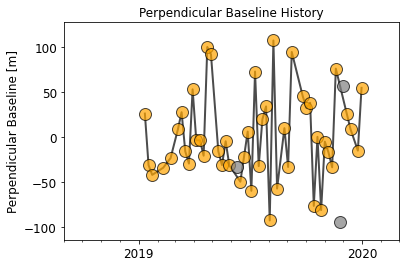

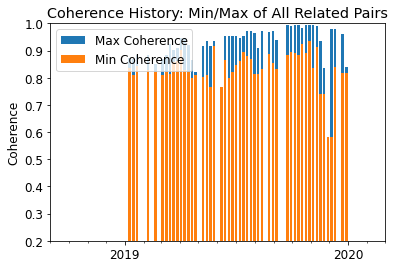

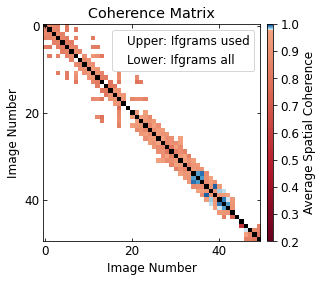

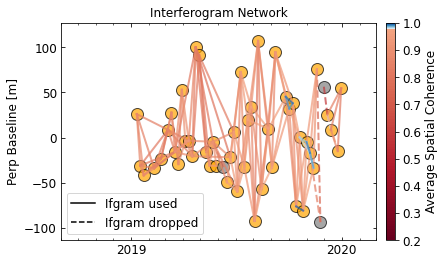

In [12]:
if not Use_Staged_Data:
    command = 'smallbaselineApp.py ' + config_file + ' --dostep modify_network'
    os.system(command);
    plot_network.main(['inputs/ifgramStack.h5'])

## 2.D Generate Quality Control Mask
<a id='generate_mask'></a>

Mask files can be can be used to mask pixels in the time-series processing. Below we generate an initial mask file `maskConnComp.h5` based on the connected components for all the interferograms, which is a metric for unwrapping quality. After time-series analysis is complete, we will calculate a mask from the temporal coherence or variation of phase or displacement with time to make `maskTempCoh.h5`.

input ifgramStack file: inputs/ifgramStack.h5
--------------------------------------------------
update mode: ON
1) output file maskConnComp.h5 already exists.
2) output file is newer than input dataset: connectComponent.
run or skip: skip.
run view.py in MintPy version v1.3.2-48, date 2022-03-23
input file is mask file: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy/maskConnComp.h5 in bool format
file size in y/x: (3001, 3361)
num of datasets in file maskConnComp.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['mask']


maskConnComp.h5


data   coverage in y/x: (0, 0, 3361, 3001)
subset coverage in y/x: (0, 0, 3361, 3001)
data   coverage in lat/lon: (-118.90125, 37.20125, -116.10041778700001, 34.700417667)
subset coverage in lat/lon: (-118.90125, 37.20125, -116.10041778700001, 34.700417667)
------------------------------------------------------------------------
colormap: jet
figure title: maskConnComp
figure size : [8.40, 6.00]
reading data ...
data has uniform and limited number (2 <= 20) of unique values --> discretize colormap
data    range: [False, True] 1
display range: [-0.5, 1.5] 1
display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
plot scale bar: [0.2, 0.2, 0.1]
plot reference point
showing ...


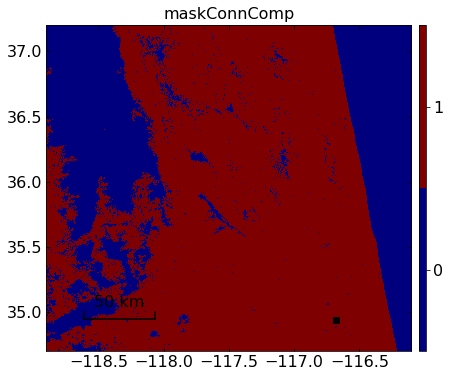

In [13]:
if not Use_Staged_Data:
    os.system('generate_mask.py inputs/ifgramStack.h5  --nonzero  -o maskConnComp.h5  --update');
    view.main(['maskConnComp.h5'])
    msk_file = os.path.join(mint_dir, 'maskTempCoh.h5')

## 2.E Reference Interferograms To Common Lat/Lon
<a id='common_latlon'></a>

In [14]:
if not Use_Staged_Data:
    command = 'smallbaselineApp.py ' + config_file + ' --dostep reference_point'
    os.system(command);
    os.system('info.py inputs/ifgramStack.h5 | egrep "REF_"');

MintPy version v1.3.2-48, date 2022-03-23
--RUN-at-2022-04-04 20:40:59.205507--
Current directory: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy
Run routine processing with smallbaselineApp.py on steps: ['reference_point']
Remaining steps: ['quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Ridgecrest_Sen
Go to work directory: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy
read custom template file: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy/Ridgecrest_Sen.txt
update default template based on input custom template
No new option value found, skip updating /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy/smallbaselineApp.cfg
copy smallbaselineApp.cfg to inputs   directory for backup.
copy smallbaselineApp.cfg t

## 2.F Invert for SBAS Line-of-Sight Timeseries
<a id='invert_SBAS'></a>

In [15]:
if not Use_Staged_Data:
    command = 'smallbaselineApp.py ' + config_file + ' --dostep invert_network'
    os.system(command);

MintPy version v1.3.2-48, date 2022-03-23
--RUN-at-2022-04-04 20:41:05.130252--
Current directory: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Ridgecrest_Sen
Go to work directory: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy
read custom template file: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy/Ridgecrest_Sen.txt
update default template based on input custom template
No new option value found, skip updating /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy/smallbaselineApp.cfg
copy smallbaselineApp.cfg to inputs   directory for backup.
copy smallbaselineApp.cfg to pic      directory for backup.
read default template file: 

# 3. Optional Corrections
<a id='opt_correction'></a>
Phase distortions related to solid earth and ocean tidal effects as well as those due to temporal variations in the vertical stratification of the atmosphere can be mitigated using the approaches described below. At this point, it is expected that these corrections will not be needed to validate the mission requirements, but they may be used to produce the highest quality data products. Typically, these are applied to the estimated time series product rather than to the individual interferograms, since they are a function of the time of each radar acquisition.

## 3.A Solid Earth Tide Correction
<a id='solid_earth'></a>
[MintPy provides functionality for this correction.]

## 3.B Tropospheric Delay Correction
<a id='tropo_corr'></a>
Optional atmospheric correction utilizes the PyAPS (Jolivet et al., 2011, Jolivet and Agram, 2012) module within GIAnT (or eventually a merged replacement for GIAnT and MintPy). PyAPS is well documented, maintained and can be freely downloaded. PyAPS is included in GIAnT distribution). PyAPS currently includes support for ECMWF’s ERA-Interim, NOAA’s NARR and NASA’s MERRA weather models. A final selection of atmospheric models to be used for operational NISAR processing will be done during Phase C.

[T]ropospheric delay maps are produced from atmospheric data provided by Global Atmospheric Models. This method aims to correct differential atmospheric delay correlated with the topography in interferometric phase measurements. Global Atmospheric Models (hereafter GAMs)... provide estimates of the air temperature, the atmospheric pressure and the humidity as a function of elevation on a coarse resolution latitude/longitude grid. In PyAPS, we use this 3D distribution of atmospheric variables to determine the atmospheric phase delay on each pixel of each interferogram.

The absolute atmospheric delay is computed at each SAR acquisition date. For a pixel a_i at an elevation z at acquisition date i, the four surrounding grid points are selected and the delays for their respective elevations are computed. The resulting delay at the pixel a_i is then the bilinear interpolation between the delays at the four grid points. Finally, we combine the absolute delay maps of the InSAR partner images to produce the differential delay maps used to correct the interferograms.

[MintPy provides functionality for this correction.]

## 3.C Phase Deramping
<a id='phase_deramp'></a>

In [16]:
if not Use_Staged_Data:
    command = 'smallbaselineApp.py ' + config_file + ' --dostep deramp'
    os.system(command);

MintPy version v1.3.2-48, date 2022-03-23
--RUN-at-2022-04-04 20:41:08.113305--
Current directory: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy
Run routine processing with smallbaselineApp.py on steps: ['deramp']
Remaining steps: ['correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Ridgecrest_Sen
Go to work directory: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy
read custom template file: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy/Ridgecrest_Sen.txt
update default template based on input custom template
No new option value found, skip updating /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy/smallbaselineApp.cfg
copy smallbaselineApp.cfg to inputs   directory for backup.
copy smallbaselineApp.cfg to pic      directory for backup.
read default template file: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy/smallbaselineAp

## 3.D Topographic Residual Correction
<a id='topo_corr'></a>
[MintPy provides functionality for this correction.]

In [17]:
if not Use_Staged_Data:
    command = 'smallbaselineApp.py ' + config_file + ' --dostep correct_topography'
    os.system(command);

MintPy version v1.3.2-48, date 2022-03-23
--RUN-at-2022-04-04 20:41:10.798390--
Current directory: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy
Run routine processing with smallbaselineApp.py on steps: ['correct_topography']
Remaining steps: ['residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Ridgecrest_Sen
Go to work directory: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy
read custom template file: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy/Ridgecrest_Sen.txt
update default template based on input custom template
No new option value found, skip updating /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy/smallbaselineApp.cfg
copy smallbaselineApp.cfg to inputs   directory for backup.
copy smallbaselineApp.cfg to pic      directory for backup.
read default template file: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy/smallbaselineApp.cfg


**

# 4. Decomposition of InSAR and GNSS time series into basis functions
<a id='decomp_ts'></a>

## 4.A Estimate InSAR LOS Velocities
<a id='estimate_vel'></a>
Given a time series of InSAR LOS displacements, the observations for a given pixel, $U(t)$, can be parameterized as:

$$U(t) = a \;+\; vt \;+\; c_1 cos (\omega_1t - \phi_{1,}) \;+\; c_2 cos (\omega_2t - \phi_2) \;+\; \sum_{j=1}^{N_{eq}} \left( h_j+f_j F_j (t-t_j) \right)H(t - t_j) \;+\; \frac{B_\perp (t)}{R sin \theta}\delta z \;+\; residual$$ 

which includes a constant offset $(a)$, velocity $(v)$, and amplitudes $(c_j)$ and phases $(\phi_j)$ of annual $(\omega_1)$ and semiannual $(\omega_2)$ sinusoidal terms.  Where needed we can include additional complexity, such as coseismic and postseismic processes parameterized by Heaviside (step) functions $H$ and postseismic functions $F$ (the latter typically exponential and/or logarithmic).   $B_\perp(t)$, $R$, $\theta$, and $\delta z$ are, respectively, the perpendicular component of the interferometric baseline relative to the first date, slant range distance, incidence angle and topography error correction for the given pixel. 

Thus, given either an ensemble of interferograms or the output of SBAS (displacement vs. time), we can write the LSQ problem as 

$$ \textbf{G}\textbf{m} = \textbf{d}$$

where $\textbf{G}$ is the design matrix (constructed out of the different functional terms in Equation 2 evaluated either at the SAR image dates for SBAS output, or between the dates spanned by each pair for interferograms), $\textbf{m}$ is the vector of model parameters (the coefficients in Equation 2) and $\textbf{d}$ is the vector of observations.  For GPS time series, $\textbf{G}, \textbf{d}, \textbf{m}$ are constructed using values evaluated at single epochs corresponding to the GPS solution times, as for SBAS InSAR input. 

With this formulation, we can obtain InSAR velocity estimates and their formal uncertainties (including in areas where the expected answer is zero). 

The default InSAR velocity fit in MintPy is to estimate a mean linear velocity $(v)$ in in the equation, which we do below. 

In [18]:
if not Use_Staged_Data:
    command = 'smallbaselineApp.py ' + config_file + ' --dostep velocity'
    os.system(command);
    vel_file = os.path.join(mint_dir, 'velocity.h5')
    vel = readfile.read(vel_file, datasetName = 'velocity')[0] * 100.  #read and convert velocities from m to cm
    # optionally set masked pixels to NaN
    #msk = readfile.read(msk_file)[0]
    #vel[msk == 0] = np.nan

MintPy version v1.3.2-48, date 2022-03-23
--RUN-at-2022-04-04 20:41:13.354853--
Current directory: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy
Run routine processing with smallbaselineApp.py on steps: ['velocity']
Remaining steps: ['geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Ridgecrest_Sen
Go to work directory: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy
read custom template file: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy/Ridgecrest_Sen.txt
update default template based on input custom template
No new option value found, skip updating /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy/smallbaselineApp.cfg
copy smallbaselineApp.cfg to inputs   directory for backup.
copy smallbaselineApp.cfg to pic      directory for backup.
read default template file: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy/smallbaselineApp.cfg


******************** step - velocity ********************


Now we plot the mean linear velocity fit. The MintPy `view` module automatically reads the temporal coherence mask `maskTempCoh.h5` and applies that to mask out pixels with unreliable velocities (white).

run view.py in MintPy version v1.3.2-48, date 2022-03-23
input file is velocity file: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy/velocity.h5 in float32 format
file size in y/x: (3001, 3361)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 4
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 3361, 3001)
subset coverage in y/x: (0, 0, 3361, 3001)
data   coverage in lat/lon: (-118.90125, 37.20125, -116.10041778700001, 34.700417667)
subset coverage in lat/lon: (-118.90125, 37.20125, -116.10041778700001, 34.700417667)
------------------------------------------------------------------------
colormap: RdBu
figure title: LOS_Velocity
figure size : [8.40, 6.00]
read mask from file: maskTempCoh.h5
reading data ...
masking data
set reference pixel to: [200, 950]
data    range: [-8.1372795, 15.587881] cm/year
display range: [-25.0, 25.0] cm/year
display data in transparency: 1.0
p

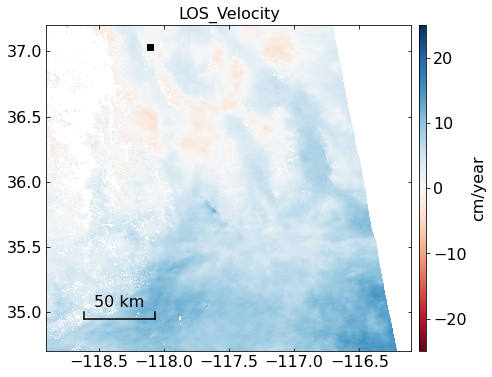

In [19]:
scp_args = 'velocity.h5 velocity -v -25 25 --ref-yx 200 950 --colormap RdBu --figtitle LOS_Velocity' # --plot-setting ' + plot_config_file
view.main(scp_args.split())

<div class="alert alert-info">
<b>Note :</b> 
Negative values indicates that target is moving away from the radar (i.e., Subsidence in case of vertical deformation).
Positive values indicates that target is moving towards the radar (i.e., uplift in case of vertical deformation). 
</div>

### 4.A.1 Estimate InSAR Coseismic Displacement
<a id='estimate_vel_cos'></a>
We can use the same time series to estimate the coseismic displacement as a Heaviside $H$ or step function at the time of an earthquake or a number $N_{eq}$ of earthquakes. In the above equation this is the $$\sum_{j=1}^{N_{eq}} \left( h_j+f_j F_j (t-t_j) \right)H(t - t_j) \;$$ set of terms. For simplicity, we consider only one earthquake and we assume the postseismic displacement functions $F$ are small compared to the coseismic displacements, so we only need to solve for the coefficient $h$ of each interferogram pixel.

We call the MintPy `timeseries2velocity.py` program again and specify the time of the earthquake $t_j$. The fit will also include the linear velocity rate separated from the step function amplitude. Both estimated coefficients have their associated uncertainties.

In [20]:
if not Use_Staged_Data:
    command = 'timeseries2velocity.py timeseries.h5 --step ' + earthquakeDate
    os.system(command);

open timeseries file: timeseries.h5
--------------------------------------------------
dates from input file: 47
['20190111', '20190117', '20190123', '20190210', '20190222', '20190306', '20190312', '20190318', '20190324', '20190330', '20190405', '20190411', '20190417', '20190423', '20190429', '20190511', '20190517', '20190523', '20190529', '20190616', '20190622', '20190628', '20190704', '20190710', '20190716', '20190722', '20190728', '20190803', '20190809', '20190815', '20190827', '20190902', '20190908', '20190926', '20191002', '20191008', '20191014', '20191020', '20191026', '20191101', '20191107', '20191113', '20191119', '20191207', '20191213', '20191225', '20191231']
--------------------------------------------------
using all dates to calculate the velocity
--------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    step       : ['20190705']
    exp        : {}
    log        : {}

velocity.h5


Now we can view the step function amplitude and the new linear velocity estimate.

run view.py in MintPy version v1.3.2-48, date 2022-03-23
input file is velocity file: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy/velocity.h5 in float32 format
file size in y/x: (3001, 3361)
input dataset: "['step20190705']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 4
datasets to exclude (0):
[]
datasets to display (1):
['step20190705']
data   coverage in y/x: (0, 0, 3361, 3001)
subset coverage in y/x: (0, 0, 3361, 3001)
data   coverage in lat/lon: (-118.90125, 37.20125, -116.10041778700001, 34.700417667)
subset coverage in lat/lon: (-118.90125, 37.20125, -116.10041778700001, 34.700417667)
------------------------------------------------------------------------
colormap: RdBu
figure title: LOS_Coseismic
figure size : [8.40, 6.00]
read mask from file: maskTempCoh.h5
reading data ...
masking data
set reference pixel to: [200, 950]
data    range: [-50.40724, 81.67334] cm
display range: [-40.0, 40.0] cm
display data in transparency: 1.0
plot

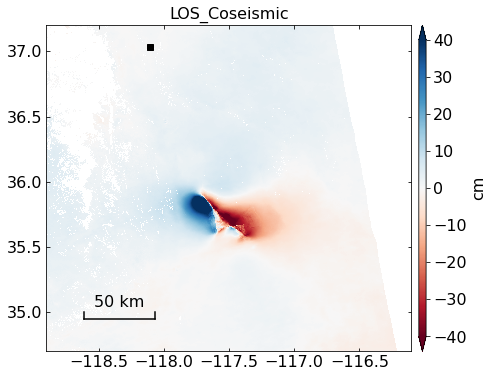

run view.py in MintPy version v1.3.2-48, date 2022-03-23
input file is velocity file: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy/velocity.h5 in float32 format
file size in y/x: (3001, 3361)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 4
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 3361, 3001)
subset coverage in y/x: (0, 0, 3361, 3001)
data   coverage in lat/lon: (-118.90125, 37.20125, -116.10041778700001, 34.700417667)
subset coverage in lat/lon: (-118.90125, 37.20125, -116.10041778700001, 34.700417667)
------------------------------------------------------------------------
colormap: RdBu
figure title: LOS_Velocity
figure size : [8.40, 6.00]
read mask from file: maskTempCoh.h5
reading data ...
masking data
set reference pixel to: [200, 950]
data    range: [-8.1372795, 15.587881] cm/year
display range: [-25.0, 25.0] cm/year
display data in transparency: 1.0
p

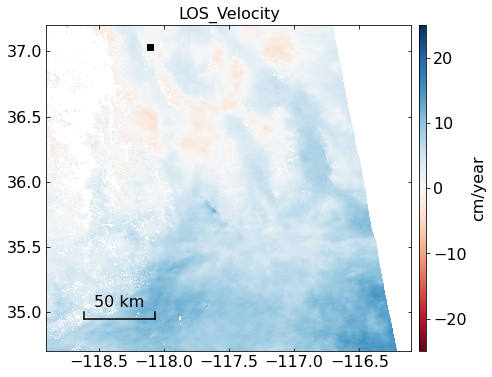

In [21]:
scp_args = 'velocity.h5 step'+earthquakeDate+' -v -40 40 --ref-yx 200 950 --colormap RdBu --figtitle LOS_Coseismic' # --plot-setting ' + plot_config_file
view.main(scp_args.split())
scp_args = 'velocity.h5 velocity -v -25 25 --ref-yx 200 950 --colormap RdBu --figtitle LOS_Velocity' # --plot-setting ' + plot_config_file
view.main(scp_args.split())

In [22]:
EQdataset = 'step'+earthquakeDate
EQstep = readfile.read(vel_file, datasetName = EQdataset)[0] * 100.  #read and convert coseismic step from m to cm

## 4.B Find Collocated GNSS Stations
<a id='find_gnss'></a>
The project will have access to L2 position data for continuous GNSS stations in third-party networks such NSF’s Plate Boundary Observatory, the HVO network for Hawaii, GEONET-Japan, and GEONET-New Zealand, located in target regions for NISAR solid earth calval. Station data will be post-processed by one or more analysis centers, will be freely available, and will have latencies of several days to weeks, as is the case with positions currently produced by the NSF’s GAGE Facility and separately by the University of Nevada Reno. Networks will contain one or more areas of high-density station coverage (2~20 km nominal station spacing over 100 x 100 km or more) to support validation of L2 NISAR requirements at a wide range of length scales.

In [23]:
# get analysis metadata from InSAR velocity file
atr = readfile.read_attribute(vel_file)
length, width = int(atr['LENGTH']), int(atr['WIDTH'])
lat_step = float(atr['Y_STEP'])
lon_step = float(atr['X_STEP'])
N = float(atr['Y_FIRST'])
W = float(atr['X_FIRST'])
S = N + lat_step * length
E = W + lon_step * width
start_date = atr.get('START_DATE', None)
end_date = atr.get('END_DATE', None)
start_date_gnss = dt.strptime(start_date, "%Y%m%d")
end_date_gnss = dt.strptime(end_date, "%Y%m%d")
inc_angle = int(float(atr.get('incidenceAngle', None)))
az_angle = int(float(atr.get('azimuthAngle', None))) 

#Set GNSS Parameters
gps_completeness_threshold = 0.9     #0.9  #percent of data timespan with valid GNSS epochs
gps_residual_stdev_threshold = 20. #0.03  #0.03  #max threshold standard deviation of residuals to linear GNSS fit

In [24]:
# search for collocated GNSS stations
site_names, site_lats, site_lons = gps.search_gps(SNWE=(S,N,W,E), start_date=start_date, end_date=end_date)
print("Initial list of {} stations used in analysis:".format(len(site_names)))
print(site_names)

Initial list of 111 stations used in analysis:
['ALPP' 'ASHM' 'BEAT' 'BEER' 'BEPK' 'BFSH' 'BSRY' 'CABS' 'CAC2' 'CAIS'
 'CAL8' 'CCCC' 'CDMT' 'CERR' 'COSJ' 'COSO' 'CPBN' 'CRAM' 'DEVL' 'DS13'
 'DTPG' 'EAGL' 'EDPP' 'ELTN' 'FOXG' 'FZHS' 'GOL2' 'GOLD' 'HAR7' 'HCMN'
 'HIGH' 'HIVI' 'HW95' 'INDE' 'ISLK' 'KENN' 'LAVA' 'LJRN' 'LNMT' 'LONP'
 'NEVA' 'NVAG' 'OASI' 'OLNC' 'OWEN' 'P091' 'P092' 'P093' 'P094' 'P311'
 'P462' 'P463' 'P464' 'P465' 'P466' 'P467' 'P468' 'P553' 'P554' 'P556'
 'P557' 'P558' 'P560' 'P567' 'P568' 'P569' 'P570' 'P571' 'P573' 'P579'
 'P580' 'P583' 'P588' 'P590' 'P591' 'P592' 'P593' 'P594' 'P595' 'P596'
 'P597' 'P604' 'P615' 'P616' 'P617' 'P618' 'P619' 'P620' 'P808' 'P811'
 'P812' 'PANA' 'PEAR' 'PHIN' 'PHLB' 'RAMT' 'REP3' 'REPO' 'RSTP' 'RYAN'
 'SHOS' 'TEHA' 'THCP' 'TIVA' 'TLCC' 'TOWG' 'TPOG' 'WASG' 'WHFG' 'WLHG'
 'WORG']


## 4.C Get GNSS Position Time Series
<a id='get_gnss'></a>

In [25]:
# get daily position solutions for GNSS stations
use_stn = []  #stations to keep
bad_stn = []  #stations to toss
use_lats = [] 
use_lons = []
counter = 0

for stn in site_names:
    gps_obj = GPS(site = stn, data_dir = mint_dir + 'GPS')
    gps_obj.open()
    
    # count number of dates in time range
    dates = gps_obj.dates
    range_days = (end_date_gnss - start_date_gnss).days
    gnss_count = np.histogram(dates, bins=[start_date_gnss,end_date_gnss])
    gnss_count = int(gnss_count[0])
    
    # for this quick screening check of data quality, we use the constant incidence and azimuth angles 
    # get standard deviation of residuals to linear fit
    disp_los = ut.enu2los(gps_obj.dis_e, gps_obj.dis_n, gps_obj.dis_u, inc_angle, az_angle)
    #disp_los = ut.enu2los(gps_obj.dis_e, gps_obj.dis_n, gps_obj.dis_u, inc_angle, head_angle, az_angle)
    disp_detrended = signal.detrend(disp_los)
    stn_stdv = np.std(disp_detrended)
   
    # select GNSS stations based on data completeness and scatter of residuals
    disp_detrended = signal.detrend(disp_los)
    if range_days*gps_completeness_threshold <= gnss_count:
        if stn_stdv > gps_residual_stdev_threshold:
            bad_stn.append(stn)
        else:
            use_stn.append(stn)
            use_lats.append(site_lats[counter])
            use_lons.append(site_lons[counter])
    else:
        bad_stn.append(stn)
    counter+=1

site_names = use_stn
site_lats = use_lats
site_lons = use_lons

calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction

In [26]:
# [optional] manually remove additional stations
site_names.remove('CAL8')
site_names.remove('P094')
site_names.remove('COSO')
site_names.remove('CAC2')
bad_stn.append('CAL8')
bad_stn.append('P094')
bad_stn.append('COSO')
bad_stn.append('CAC2')
print("Final list of {} stations used in analysis:".format(len(site_names)))
print(site_names)
print("List of {} stations removed from analysis".format(len(bad_stn)))
print(bad_stn)

Final list of 71 stations used in analysis:
['BEPK', 'BSRY', 'CABS', 'CAIS', 'CCCC', 'CDMT', 'CPBN', 'DS13', 'DTPG', 'EDPP', 'FZHS', 'GOL2', 'HAR7', 'HCMN', 'HIVI', 'ISLK', 'LJRN', 'LNMT', 'NEVA', 'NVAG', 'P091', 'P092', 'P093', 'P311', 'P462', 'P463', 'P464', 'P465', 'P466', 'P467', 'P468', 'P554', 'P556', 'P557', 'P558', 'P560', 'P567', 'P568', 'P569', 'P570', 'P573', 'P579', 'P580', 'P583', 'P588', 'P590', 'P591', 'P592', 'P593', 'P594', 'P595', 'P596', 'P597', 'P604', 'P615', 'P616', 'P617', 'P618', 'P619', 'P620', 'P808', 'P811', 'P812', 'RAMT', 'REPO', 'RSTP', 'SHOS', 'THCP', 'TPOG', 'WHFG', 'WORG']
List of 40 stations removed from analysis
['ALPP', 'ASHM', 'BEAT', 'BEER', 'BFSH', 'CERR', 'COSJ', 'CRAM', 'DEVL', 'EAGL', 'ELTN', 'FOXG', 'GOLD', 'HIGH', 'HW95', 'INDE', 'KENN', 'LAVA', 'LONP', 'OASI', 'OLNC', 'OWEN', 'P553', 'P571', 'PANA', 'PEAR', 'PHIN', 'PHLB', 'REP3', 'RYAN', 'TEHA', 'TIVA', 'TLCC', 'TOWG', 'WASG', 'WLHG', 'CAL8', 'P094', 'COSO', 'CAC2']


## 4.D Make GNSS LOS Velocities
<a id='make_gnss'></a>

As a first approximation to estimate coseismic displacements, we take one day before and one (or three) day after earthquake.

In [27]:
EQdate_int = int(earthquakeDate)
EQpre_date = str(int(earthquakeDate) - 1)  # should convert to real date object first
EQpost_date = str(int(earthquakeDate) + 3)

from mintpy.utils import readfile, utils as ut
oldStyle = False

insarFile = 'timeseries.h5' # need to use a different input file than velocity to get the displacements
gps_comp = 'enu2los'
if oldStyle:
    site_vels = gps.get_gps_los_obs(  ## this method call calculates displacements if we give non-velocity file
        insar_file=insarFile,
        site_names=site_names,
        start_date=str(EQpre_date),
        end_date=str(EQpost_date),
        gps_comp=gps_comp,
        redo=True) * 100.
    print(site_vels)

gps_comp = 'enu2los'
meta = readfile.read_attribute('velocity.h5')
SNWE = ut.four_corners(meta)
#vel = gps.get_gps_los_obs(meta, 'velocity',     site_names, start_date='20150101', end_date='20190619')
displ = gps.get_gps_los_obs(meta, 'displacement', site_names, start_date=EQpre_date, end_date=EQpost_date,gps_comp=gps_comp, redo=True) * 100.
print(displ)


default GPS observation file name: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy/gps_enu2los.csv
calculating GPS observation ...
use incidence / azimuth angle from file: geometryGeo.h5
[==================================================] 71/71 WORG   23s /     0s 
write GPS observations to file: /Users/fielding/Downloads/ATBD/calval/Ridgecrest/MintPy/gps_enu2los.csv
[ 4.9299450e+00  3.7337542e-01  5.4339767e-01  5.8870912e-01
  3.5291493e+00  1.5223026e-02  2.8041601e-01 -1.3486832e+00
  1.5788078e-01  1.6287565e-01  4.0108562e-01 -2.4391592e+00
  3.2690167e-01 -4.8875809e-02  1.0552406e-01  6.9824457e-01
  9.6690655e-01 -6.4727068e-01  2.8763860e-01  1.9738078e-01
  6.2394142e-01  6.9248974e-01  4.4144094e-01  9.2345476e-02
 -8.7174773e-01 -9.4861239e-01  3.2577515e+00  5.0868988e-01
  1.0658741e+00  2.0172894e-01  2.6366711e-01  3.4711957e-01
  1.0363817e+00  8.5746348e-01  4.4808388e-01  3.0789375e-01
  4.6874881e-01  7.3555708e-01  6.7520142e-01  2.8681874e+00
  1.7026037

calculating station lat/lon
reading time and displacement in east/north/vertical direction
fit parameters (constant, linear velocity, step) [0.10637503 0.00127193 0.1153183 ]


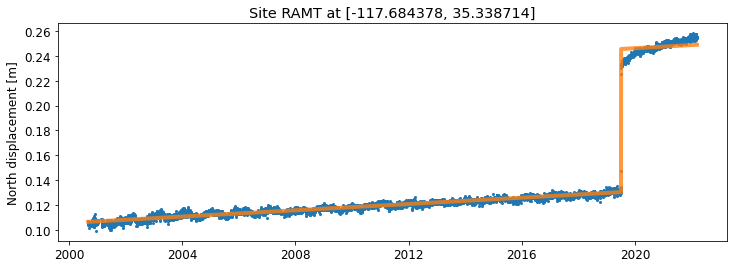

In [28]:
from mintpy.utils import ptime, time_func
# 1. download & read GNSS displacement time series
site_id = 'RAMT'
gps_obj = gps.GPS(site=site_id, data_dir = mint_dir + 'GPS')
gps_obj.open()

# 2. fit time function
model = {
    'polynomial' : 1,
    'step'       : [earthquakeDate]
}
G, m, e2 = time_func.estimate_time_func(model, gps_obj.date_list, gps_obj.dis_n)

print('fit parameters (constant, linear velocity, step)',m)

# 3. reconstruct time series from estimated time function parameters
date_list_fit = ptime.get_date_range(gps_obj.date_list[0], gps_obj.date_list[-1])
dates_fit = ptime.date_list2vector(date_list_fit)[0]
G_fit = time_func.get_design_matrix4time_func(date_list_fit, model)
dis_ts_fit = np.matmul(G_fit, m)

# plot
fig, ax = plt.subplots(figsize=[12, 4])
ax.plot(gps_obj.dates, gps_obj.dis_n, '.', ms=4)
ax.plot(dates_fit, dis_ts_fit, lw=4, alpha=0.8)
ax.set_ylabel('North displacement [m]')
ax.set_title(f'Site {site_id} at [{gps_obj.site_lon:.6f}, {gps_obj.site_lat:.6f}]')
plt.show()

calculating station lat/lon
reading time and displacement in east/north/vertical direction
fit parameters (constant, linear velocity, step) [-0.05169265  0.01141404 -0.01640655]


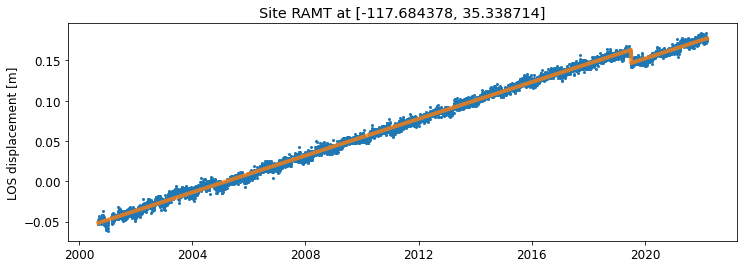

In [29]:
# get InSAR geometry file
geom_file = ut.get_geometry_file(['incidenceAngle','azimuthAngle'], work_dir=mint_dir, coord='geo')

# 1. download & read GNSS displacement time series
site_id = 'RAMT'
gps_obj = gps.GPS(site=site_id, data_dir = mint_dir + 'GPS')
gps_obj.open()

# 2. fit time function
model = {
    'polynomial' : 1,
    'step'       : [earthquakeDate]
}
# project the GNSS three components to InSAR LOS
#dis_los = ut.enu2los(gps_obj.dis_e,gps_obj.dis_n,gps_obj.dis_u,inc_angle,az_angle)

# fit whole time series for this station
# date range for this station
statStart = gps_obj.date_list[0]
statEnd = gps_obj.date_list[-1]

dates, dis_los, std, site_lalo, ref_site_lalo = gps_obj.read_gps_los_displacement(geom_file, start_date=statStart, end_date=statEnd, ref_site=None,
                                  gps_comp=gps_comp, print_msg=False)

G, m, e2 = time_func.estimate_time_func(model, gps_obj.date_list, dis_los)

print('fit parameters (constant, linear velocity, step)',m)

# 3. reconstruct time series from estimated time function parameters
date_list_fit = ptime.get_date_range(statStart, statEnd)
dates_fit = ptime.date_list2vector(date_list_fit)[0]
G_fit = time_func.get_design_matrix4time_func(date_list_fit, model)
dis_ts_fit = np.matmul(G_fit, m)

# plot
fig, ax = plt.subplots(figsize=[12, 4])
ax.plot(gps_obj.dates, dis_los, '.', ms=4)
ax.plot(dates_fit, dis_ts_fit, lw=4, alpha=0.8)
ax.set_ylabel('LOS displacement [m]')
ax.set_title(f'Site {site_id} at [{gps_obj.site_lon:.6f}, {gps_obj.site_lat:.6f}]')
plt.show()

Now do the LOS fits for all good GPS stations

In [30]:
from mintpy.utils import ptime, time_func
gnss_los_coseis_cm = []
plotGNSSfit = False

# need to update these to keep consistent
site_lats = []
site_lons = []

twoQuake = False
# fit time function
if twoQuake:
    modelParam = {
        'polynomial' : 1,
        'step'       : [earthquakeDate,earthquakeDate2],
    }
else:
    modelParam = {
        'polynomial' : 1,
        'step'       : [earthquakeDate],
    }

for stn in site_names:
    gps_obj = GPS(site = stn, data_dir = mint_dir + 'GPS')
    gps_obj.open()
    
    site_lats.append(gps_obj.site_lat) # save site location in list
    site_lons.append(gps_obj.site_lon)
    
    # fit whole time series for this station
    # date range for this station
    statStart = gps_obj.date_list[0]
    statEnd = gps_obj.date_list[-1]

    dates, dis_los, std, site_lalo, ref_site_lalo = gps_obj.read_gps_los_displacement(geom_file, start_date=statStart, end_date=statEnd, ref_site=None,
                                  gps_comp=gps_comp, print_msg=False)

    
    G, m, e2 = time_func.estimate_time_func(model, gps_obj.date_list, dis_los)

    print('station',stn,'fit parameters (constant, linear velocity, step)',m)
    gnss_los_coseis_cm.append(m[2]*100.)  # save step function and convert to cm for convenience
    
    if (plotGNSSfit):
        # 3. reconstruct time series from estimated time function parameters
        date_list_fit = ptime.get_date_range(gps_obj.date_list[0], gps_obj.date_list[-1])
        dates_fit = ptime.date_list2vector(date_list_fit)[0]
        G_fit = time_func.get_design_matrix4time_func(date_list_fit, model)
        dis_ts_fit = np.matmul(G_fit, m)
        
        dates = gps_obj.date_list
        index_start = dates.index(gps_obj.date_list[0])
        index_end = dates.index(gps_obj.date_list[-1])
        print ('index_start',index_start,'end',index_end)
        print('len dates',len(dates),'dis_los',len(dis_los),'dates_fit',len(dates_fit))
        cut_dates = dates[index_start:index_end]
        cut_dates_vec = ptime.date_list2vector(cut_dates)[0]
        cut_dis_los = dis_los[index_start:index_end]

        # plot
        fig, ax = plt.subplots(figsize=[12, 4])
        ax.plot(cut_dates_vec, cut_dis_los, '.', ms=4)
        ax.plot(dates_fit, dis_ts_fit, lw=4, alpha=0.8)
        ax.set_ylabel('LOS displacement [m]')
        ax.set_title(f'Site {stn} at [{gps_obj.site_lon:.6f}, {gps_obj.site_lat:.6f}]')
        plt.show()
        
    
print(gnss_los_coseis_cm)

calculating station lat/lon
reading time and displacement in east/north/vertical direction
station BEPK fit parameters (constant, linear velocity, step) [-0.39555383  0.01301643  0.05682849]
calculating station lat/lon
reading time and displacement in east/north/vertical direction
station BSRY fit parameters (constant, linear velocity, step) [ 0.7640582   0.01335674 -0.00604314]
calculating station lat/lon
reading time and displacement in east/north/vertical direction
station CABS fit parameters (constant, linear velocity, step) [-0.4043428   0.01341166 -0.00240505]
calculating station lat/lon
reading time and displacement in east/north/vertical direction
station CAIS fit parameters (constant, linear velocity, step) [0.07304276 0.01383696 0.01241665]
calculating station lat/lon
reading time and displacement in east/north/vertical direction
station CCCC fit parameters (constant, linear velocity, step) [0.29369676 0.01252496 0.04331382]
calculating station lat/lon
reading time and displa

In [31]:
# compare the simple difference displacements to the time-series step fits
dispDiff = displ - gnss_los_coseis_cm
print('difference in displacement estimate (cm)\n',dispDiff)
print('difference in coseismic displacement estimate (%)\n',(displ+gnss_los_coseis_cm)/2)

difference in displacement estimate (cm)
 [-0.75290377  0.97768907  0.78390299 -0.65295594 -0.80223307  1.04324985
  0.43387099  0.44125523  0.72256671  0.04218018  0.38159285  2.16171257
  0.33306368  0.78608319  0.25179881 -0.74317353  0.96128986  0.25083851
  0.26894705  0.67701973 -0.08145999  0.09163157  0.28617668 -0.46779667
  1.06757153  0.61459187 -0.28325245 -0.31306837  0.36793104 -0.27096868
  0.14110275  0.50355217  1.04374978  0.83898682  0.26826615  0.51073332
  0.14955902  0.47490499 -0.06280211  0.39795358  0.05244911  0.03456327
  1.80838704  0.59083336  0.5116242   0.34776744  0.55756276  0.73378433
  0.56155007  0.27897793  2.33125412  1.18738469  1.93778113  1.30341537
  0.69172798  0.3319141   1.92686189  1.24061238  1.44529697  1.04696751
 -0.48705098  0.30720746  0.19252716  0.30892361  0.22554146  0.27227165
  1.4017066   0.23636378  0.4002797   0.29391423 -0.4764393 ]
difference in coseismic displacement estimate (%)
 [ 5.30639688e+00 -1.15469121e-01  1.514461

## 4.E  Re-Reference GNSS and InSAR LOS Coseismic step
<a id='reref_gnss'></a>

In [32]:
# reference GNSS stations to GNSS reference site
ref_site_ind = site_names.index(gps_ref_site_name)
displRelRef = displ - displ[ref_site_ind]

# reference InSAR to GNSS reference site
ref_site_lat = float(site_lats[ref_site_ind])
ref_site_lon = float(site_lons[ref_site_ind])
ref_y, ref_x = ut.coordinate(atr).geo2radar(ref_site_lat, ref_site_lon)[:2]
print ('new reference pixel for InSAR y,x:',ref_y, ref_x,'at lat, lon',ref_site_lat,ref_site_lon)
EQstep = EQstep - EQstep[ref_y, ref_x]

new reference pixel for InSAR y,x: 1846 510 at lat, lon 35.66226995995773 -118.47591732475081


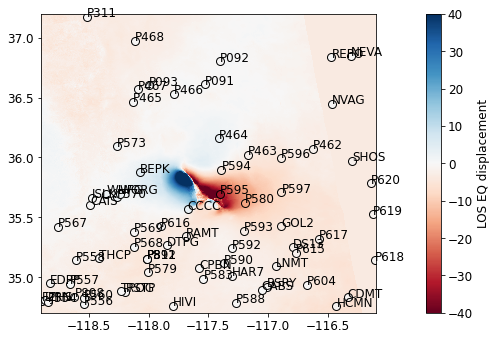

In [33]:
# plot GNSS stations on InSAR coseismic field
vmin, vmax = -40, 40
cmap = plt.get_cmap('RdBu')

fig, ax = plt.subplots(figsize=[18, 5.5])
img1 = ax.imshow(EQstep, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest', extent=(W, E, S, N))
cbar1 = fig.colorbar(img1, ax=ax)
cbar1.set_label('LOS EQ displacement')

for lat, lon, obs in zip(site_lats, site_lons, displRelRef):
    color = cmap((obs - vmin)/(vmax - vmin))
    ax.scatter(lon, lat, color=color, s=8**2, edgecolors='k')
for i, label in enumerate(site_names):
     plt.annotate(label, (site_lons[i], site_lats[i]), color='black')

out_fig = os.path.abspath('coseismic_insar_vs_gnss.png')
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

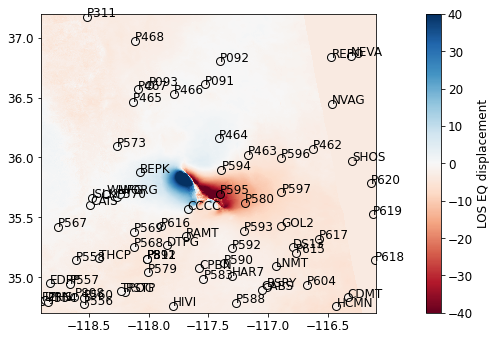

In [34]:
# same re-reference for the time-series GNSS fit
ref_site_ind = site_names.index(gps_ref_site_name)
displFitRelRef = gnss_los_coseis_cm - gnss_los_coseis_cm[ref_site_ind]

# plot GNSS stations on InSAR coseismic field
vmin, vmax = -40, 40
cmap = plt.get_cmap('RdBu')

fig, ax = plt.subplots(figsize=[18, 5.5])
img1 = ax.imshow(EQstep, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest', extent=(W, E, S, N))
cbar1 = fig.colorbar(img1, ax=ax)
cbar1.set_label('LOS EQ displacement')

for lat, lon, obs in zip(site_lats, site_lons, displFitRelRef):
    color = cmap((obs - vmin)/(vmax - vmin))
    ax.scatter(lon, lat, color=color, s=8**2, edgecolors='k')
for i, label in enumerate(site_names):
     plt.annotate(label, (site_lons[i], site_lats[i]), color='black')

out_fig = os.path.abspath('coseismic_insar_vs_gnss_fit.png')
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

# 5. NISAR Validation: GNSS-InSAR Direct Comparison Using Time-series Displacement Fit
<a id='nisar_validation'></a>

## 5.A Make Displacement Residuals at GNSS Locations
<a id='make_vel'></a>

In [35]:
#Set Parameters
pixel_radius = 5   #number of InSAR pixels to average for comparison with GNSS

#Create dictionary with the stations as the key and all their info as an array 
stn_dict = {}  

#Loop over GNSS station locations
for i in range(0,len(site_names)): 
    
    # convert GNSS station lat/lon information to InSAR x/y grid
    stn_lat = site_lats[i]
    stn_lon = site_lons[i]
    x_value = round((stn_lon - W)/lon_step)
    y_value = round((stn_lat - N)/lat_step)
    
    # get velocities and residuals
    disp_GPS = displ[i]
    #Caution: If you expand the radius parameter farther than the bounding grid it will break. 
    #To fix, remove the station in section 4 when the site_names list is filtered
    disp_px_rad = EQstep[y_value-pixel_radius:y_value+1+pixel_radius, 
                     x_value-pixel_radius:x_value+1+pixel_radius]
    disp_InSAR = np.median(disp_px_rad)
    residual = disp_GPS - disp_InSAR

    # populate data structure
    values = [x_value, y_value, disp_InSAR, disp_GPS, residual, stn_lat, stn_lon]
    stn = site_names[i]
    stn_dict[stn] = values
    
# extract data from structure
res_list = []
insar_disp = []
gnss_disp = []
lat_list = []
lon_list = []
for i in range(len(site_names)): 
    stn = site_names[i]
    insar_disp.append(stn_dict[stn][2])
    gnss_disp.append(stn_dict[stn][3])
    res_list.append(stn_dict[stn][4])
    lat_list.append(stn_dict[stn][5])
    lon_list.append(stn_dict[stn][6])
num_stn = len(site_names) 

## 5.B Make Double-differenced Velocity Residuals
<a id='make_velres'></a>

In [36]:
diff_res_list = []
stn_dist_list = []
dict_keys = list(stn_dict.keys())

# remove reference stn
site_names_analysis = list(site_names)
#site_names_analysis.remove(gps_ref_site_name)

# loop over stations
for i in range(len(site_names_analysis)-1):
    stn1 = dict_keys[i]
    for l in range(i + 1, len(dict_keys)):
        stn2 = dict_keys[l]
        # calculate between-station velocity residual
        # stn_dict values = [x_value, y_value, vel_InSAR, vel_GPS, residual, stn_lat, stn_lon]
        # index 3 = gps vel
        gps_vel_diff = stn_dict[stn1][3] - stn_dict[stn2][3]
        # index 2 = insar vel 
        insar_vel_diff = stn_dict[stn1][2]-stn_dict[stn2][2]
        # calculate double-difference
        diff_res = gps_vel_diff - insar_vel_diff
        diff_res_list.append(diff_res)
        # get distance between selected station
        # index 5 is lat, 6 is lon
        dlat = (stn_dict[stn1][5]-stn_dict[stn2][5])
        dlon = (stn_dict[stn1][6]-stn_dict[stn2][6])*np.sin(stn_dict[stn1][5])
        #convert degrees to km
        stn_dist = math.sqrt(dlat**2 + dlon**2)*111
        stn_dist_list.append(stn_dist)

## 5.C Compare Raw Velocities
<a id='compare_raw'></a>

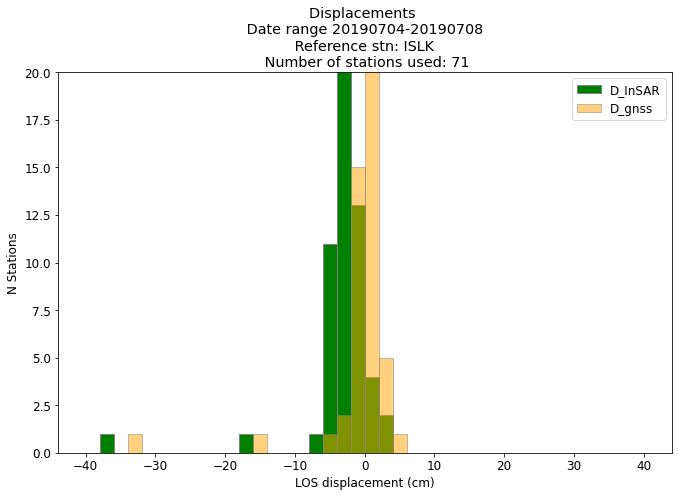

In [37]:
vmin, vmax = -40, 40
plt.figure(figsize=(11,7))
plt.hist(insar_disp, range = [vmin, vmax],bins = 40, color = "green",edgecolor='grey',label='D_InSAR')
plt.hist(gnss_disp, range = [vmin, vmax],bins = 40, color = "orange",edgecolor='grey',label='D_gnss', alpha=0.5)
plt.legend(loc='upper right')
plt.title(f"Displacements \n Date range {EQpre_date}-{EQpost_date} \n Reference stn: {gps_ref_site_name} \n Number of stations used: {num_stn}")
plt.xlabel('LOS displacement (cm)')
plt.ylabel('N Stations')
plt.ylim(0,20)
plt.show()

## 5.D Plot Velocity Residuals
<a id='plot_vel'></a>

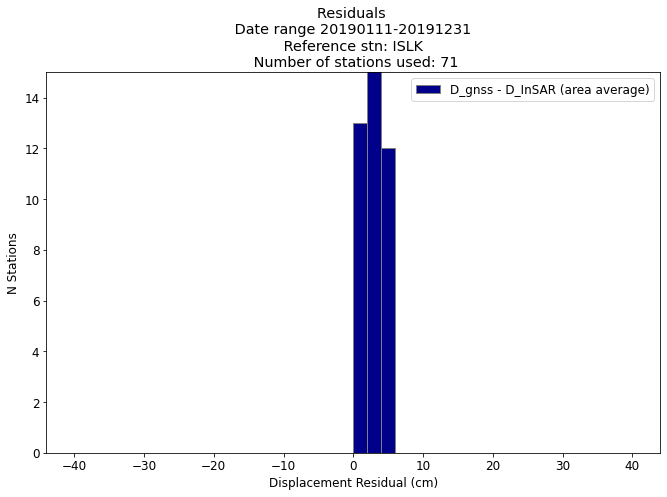

In [38]:
plt.figure(figsize=(11,7))
plt.hist(res_list,bins = 40, range = [vmin, vmax],edgecolor='grey',color="darkblue",linewidth=1,label='D_gnss - D_InSAR (area average)')
plt.legend(loc='upper right')
plt.title(f"Residuals \n Date range {start_date}-{end_date} \n Reference stn: {gps_ref_site_name} \n Number of stations used: {num_stn}")
plt.xlabel('Displacement Residual (cm)')
plt.ylabel('N Stations')
plt.ylim(0,15)
plt.show()

## 5.E Plot Double-differenced Residuals
<a id='plot_velres'></a>

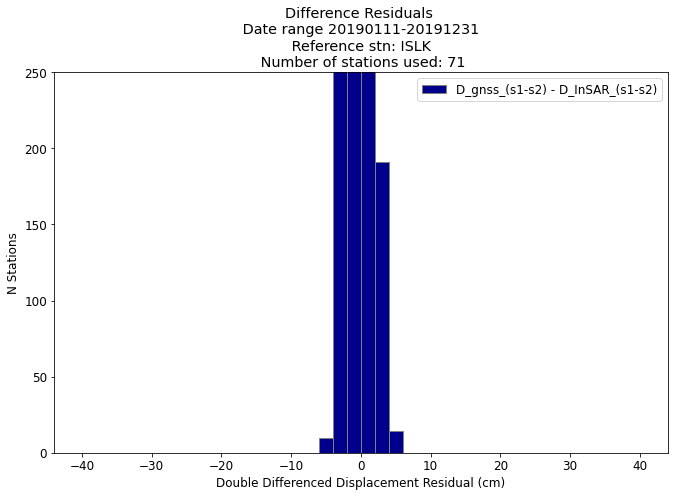

In [39]:
plt.figure(figsize=(11,7))
plt.hist(diff_res_list, range = [vmin, vmax],bins = 40, color = "darkblue",edgecolor='grey',label='D_gnss_(s1-s2) - D_InSAR_(s1-s2)')
plt.legend(loc='upper right')
plt.title(f"Difference Residuals \n Date range {start_date}-{end_date} \n Reference stn: {gps_ref_site_name} \n Number of stations used: {num_stn}")
plt.xlabel('Double Differenced Displacement Residual (cm)')
plt.ylabel('N Stations')
plt.ylim(0,250)
plt.show()

## 5.F Amplitude vs. Distance of Double Differences (not quite a structure function)
<a id='plot_velres'></a>

In [40]:
dist_th = np.linspace(0.1,50,100)  # distances for evaluation
acpt_error = 4*(1+np.sqrt(dist_th))  # coseismic threshold in mm
acpt_error_cm = acpt_error/10.
abs_ddiff_disp = [abs(i) for i in diff_res_list]

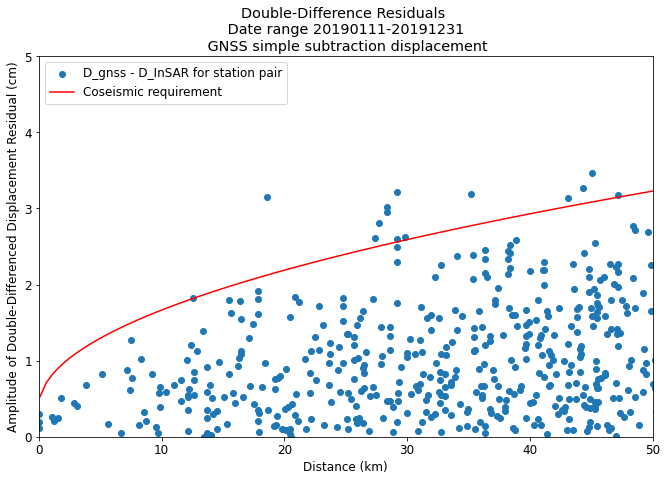

In [41]:
fig, ax = plt.subplots(figsize=(11,7))
plt.scatter(stn_dist_list,abs_ddiff_disp,label='D_gnss - D_InSAR for station pair')
plt.plot(dist_th, acpt_error_cm, 'r',label='Coseismic requirement')
plt.ylim(0,5)
plt.xlim(0,50)
plt.legend(loc='upper left')
plt.title(f"Double-Difference Residuals \n Date range {start_date}-{end_date} \n GNSS simple subtraction displacement")
plt.xlabel("Distance (km)")
plt.ylabel("Amplitude of Double-Differenced Displacement Residual (cm)")
plt.show()

out_fig = os.path.abspath('coseismic_insar-gnss_vs_distance.png')
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

# 6. NISAR Validation: InSAR Residuals Analysis
<a id='nisar_anal'></a>

In [42]:
# version of GNSS coseismic displacements from full time-series fit
#Create dictionary with the stations as the key and all their info as an array 
stn_fit_dict = {}  

#Loop over GNSS station locations
for i in range(0,len(site_names)): 
    
    # convert GNSS station lat/lon information to InSAR x/y grid
    # convert GNSS station lat/lon information to InSAR x/y grid
    stn_lat = site_lats[i]
    stn_lon = site_lons[i]
    x_value = round((stn_lon - W)/lon_step)
    y_value = round((stn_lat - N)/lat_step)
    
    # get velocities and residuals
    disp_GPS_fit = gnss_los_coseis_cm[i]
    #Caution: If you expand the radius parameter farther than the bounding grid it will break. 
    #To fix, remove the station in section 4 when the site_names list is filtered
    disp_px_rad = EQstep[y_value-pixel_radius:y_value+1+pixel_radius, 
                     x_value-pixel_radius:x_value+1+pixel_radius]
    disp_InSAR = np.median(disp_px_rad)

    residual_fit = disp_GPS_fit - disp_InSAR

    # populate data structure
    values = [x_value, y_value, disp_InSAR, disp_GPS_fit, residual, stn_lat, stn_lon]
    stn = site_names[i]
    stn_fit_dict[stn] = values
    
# extract data from structure
res_list = []
insar_disp = []
gnss_disp = []
lat_list = []
lon_list = []
for stn in site_names: 
    insar_disp.append(stn_fit_dict[stn][2])
    gnss_disp.append(stn_fit_dict[stn][3])
    res_list.append(stn_fit_dict[stn][4])
    lat_list.append(stn_fit_dict[stn][5])
    lon_list.append(stn_fit_dict[stn][6])
num_stn = len(site_names) 

## 6.A Make Double-differenced Velocity Residuals
<a id='make_velres2'></a>

In [43]:
stn_dict=stn_fit_dict # use the fit displacements for the rest of the calculations

diff_res_fit_list = []
stn_dist_list = []
dict_keys = list(stn_dict.keys())

# remove reference stn
site_names_analysis = list(site_names)
#site_names_analysis.remove(gps_ref_site_name)

# loop over stations
for i in range(len(site_names_analysis)-1):
    stn1 = dict_keys[i]
    for l in range(i + 1, len(dict_keys)):
        stn2 = dict_keys[l]
        # calculate between-station velocity residual
        # stn_dict values = [x_value, y_value, vel_InSAR, vel_GPS, residual, stn_lat, stn_lon]
        # index 3 = gps vel
        gps_vel_diff = stn_dict[stn1][3] - stn_dict[stn2][3]
        # index 2 = insar vel 
        insar_vel_diff = stn_dict[stn1][2]-stn_dict[stn2][2]
        # calculate double-difference
        diff_res = gps_vel_diff - insar_vel_diff
        diff_res_fit_list.append(diff_res)
        # get distance between selected station
        # index 5 is lat, 6 is lon
        dlat = (stn_dict[stn1][5]-stn_dict[stn2][5])
        dlon = (stn_dict[stn1][6]-stn_dict[stn2][6])*np.sin(stn_dict[stn1][5])
        #convert degrees to km
        stn_dist = math.sqrt(dlat**2 + dlon**2)*111
        stn_dist_list.append(stn_dist)

## 6.B Amplitude vs. Distance of Double-differences (not quite a structure function)
<a id='ampvsdist2'></a>

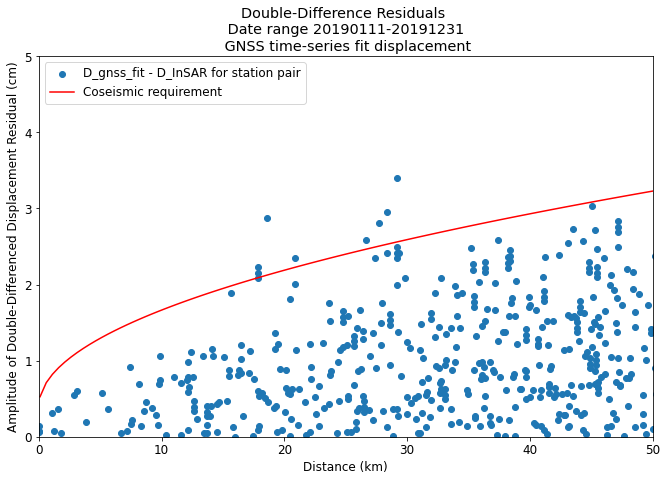

In [44]:
abs_ddiff_disp_fit = [abs(i) for i in diff_res_fit_list]

fig, ax = plt.subplots(figsize=(11,7))
plt.scatter(stn_dist_list,abs_ddiff_disp_fit,label='D_gnss_fit - D_InSAR for station pair')
plt.plot(dist_th, acpt_error_cm, 'r',label='Coseismic requirement')
plt.ylim(0,5)
plt.xlim(0,50)
plt.legend(loc='upper left')
plt.title(f"Double-Difference Residuals \n Date range {start_date}-{end_date} \n GNSS time-series fit displacement")
plt.xlabel("Distance (km)")
plt.ylabel("Amplitude of Double-Differenced Displacement Residual (cm)")
plt.show()

out_fig = os.path.abspath('coseismic_insar-gnss_fit_vs_distance.png')
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

# Appendix: GPS Position Plots
<a id='appendix_gps'></a>

calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction

/var/folders/92/tx_tbh3d05x_gpx6ydy5nmd94bbnb9/T/ipykernel_76621/1708888203.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15,5))


calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction

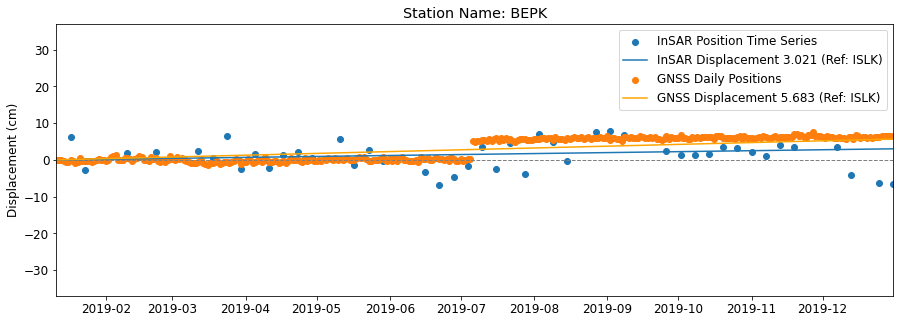

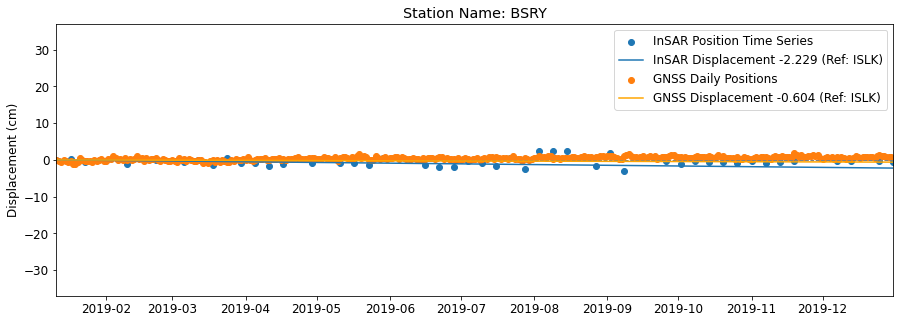

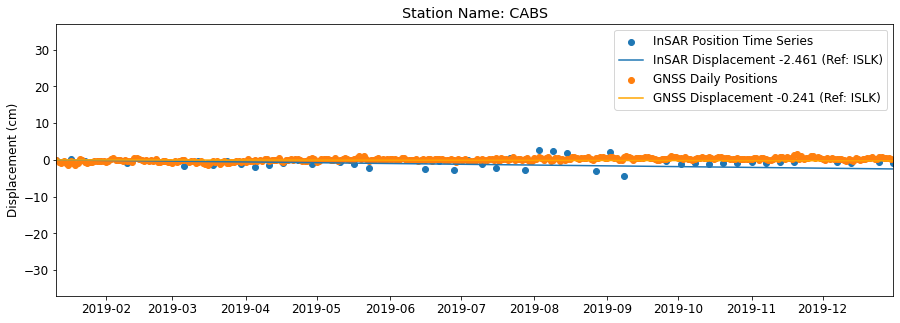

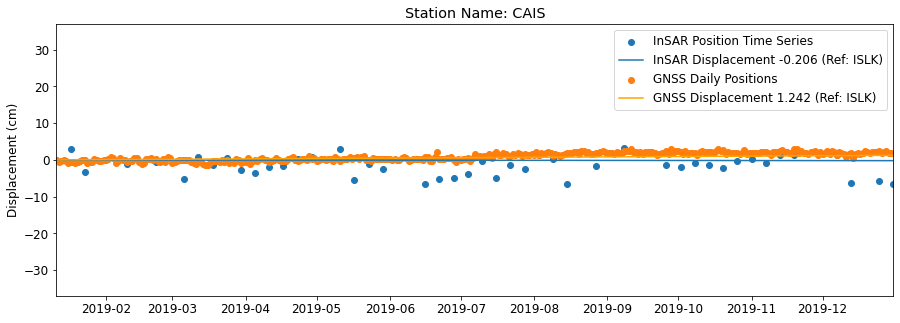

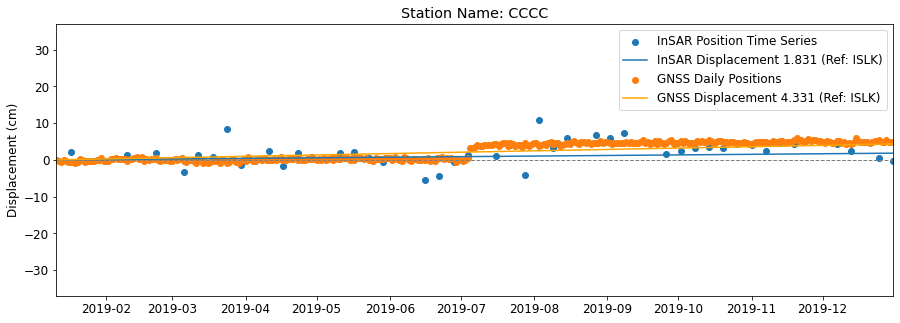

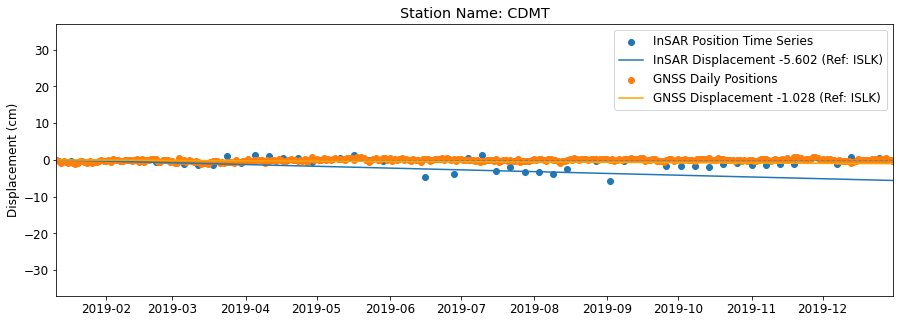

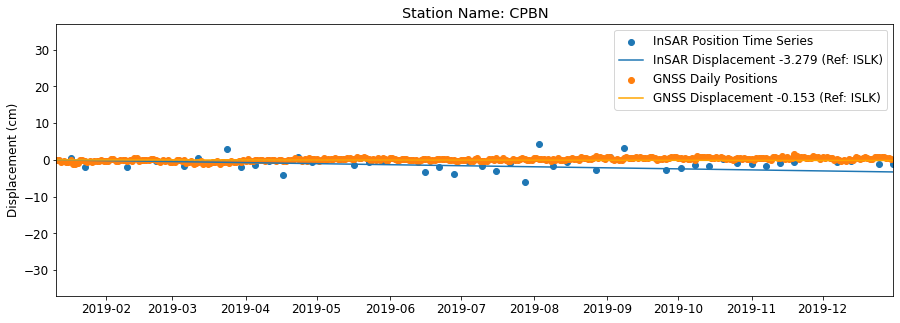

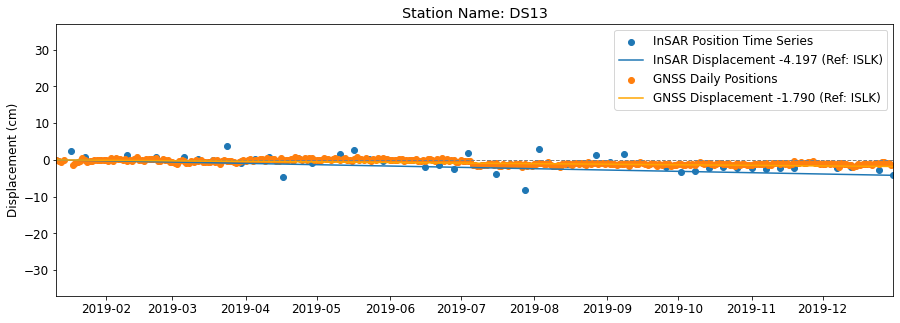

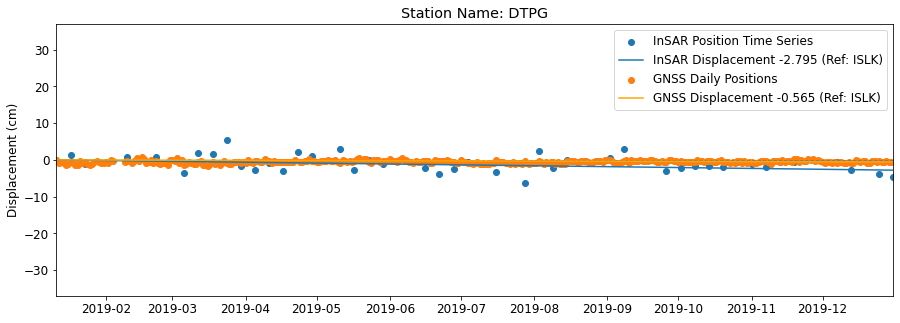

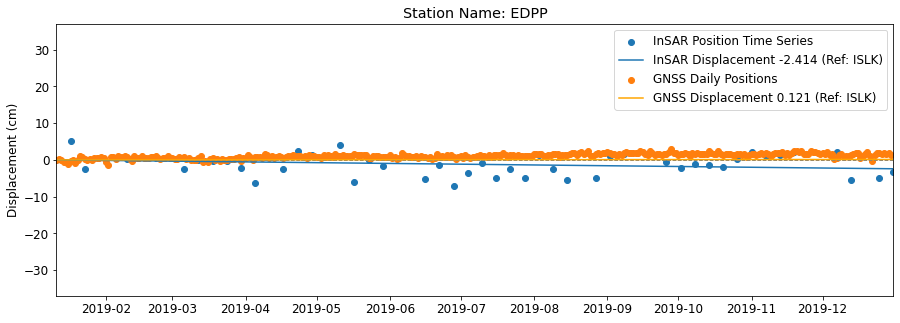

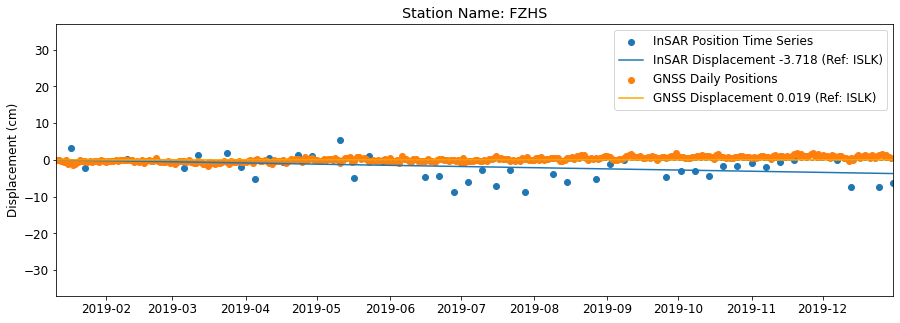

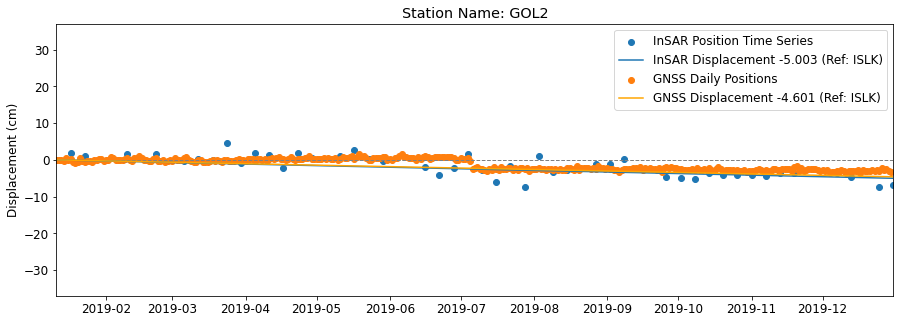

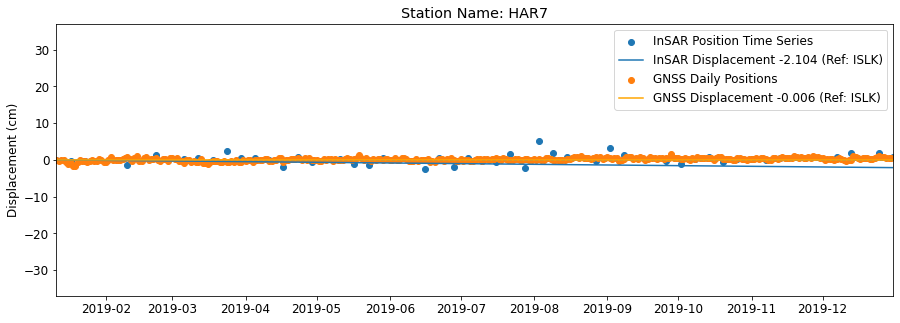

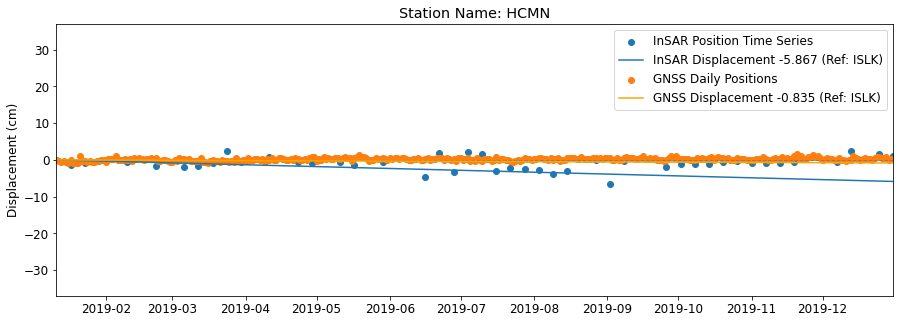

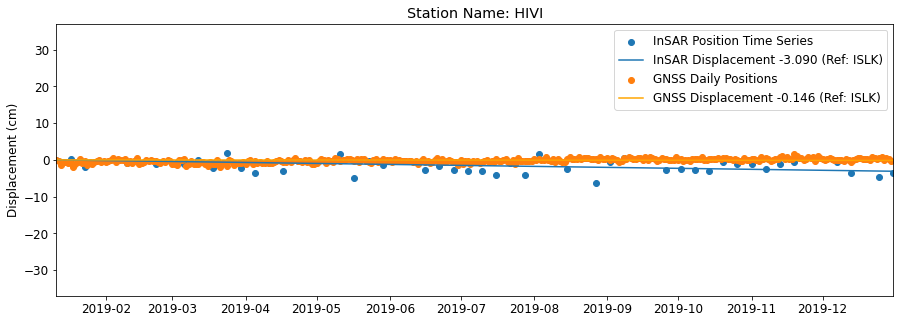

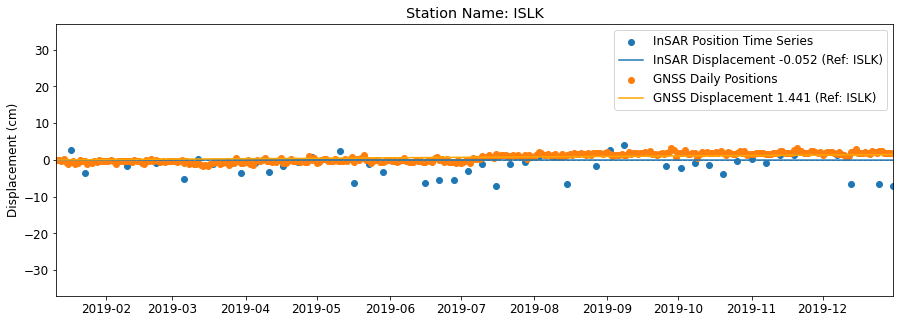

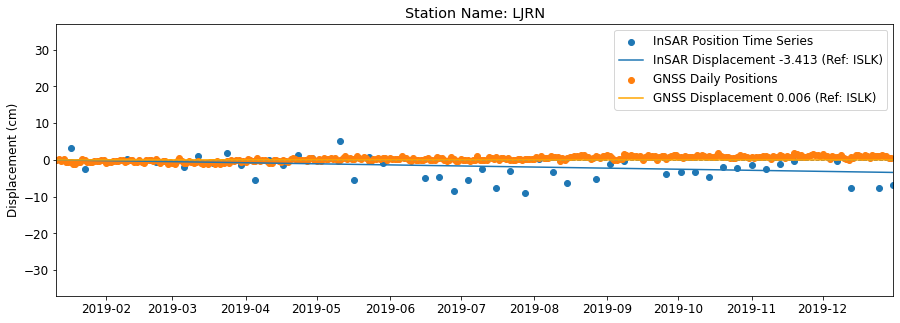

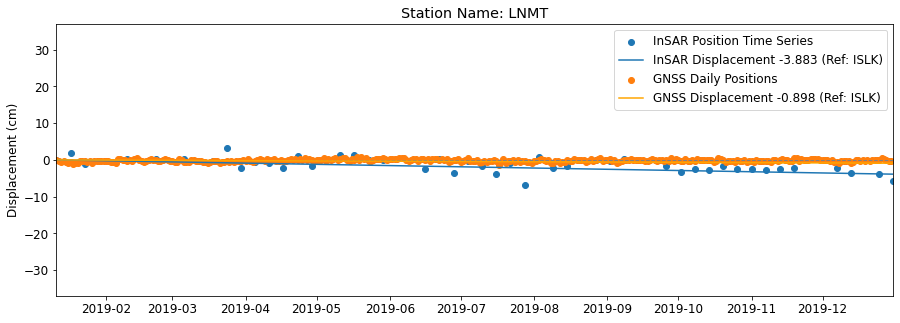

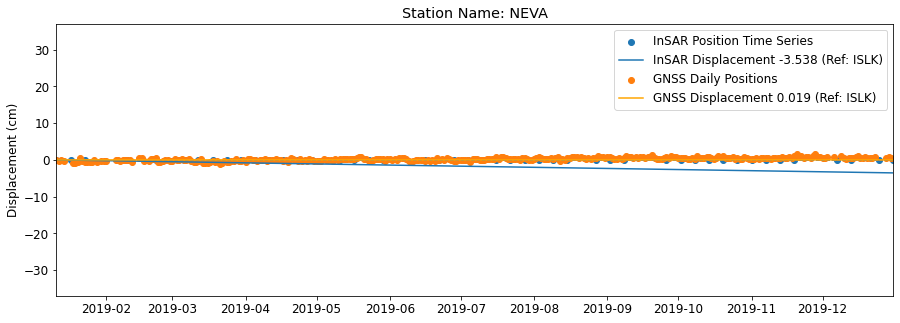

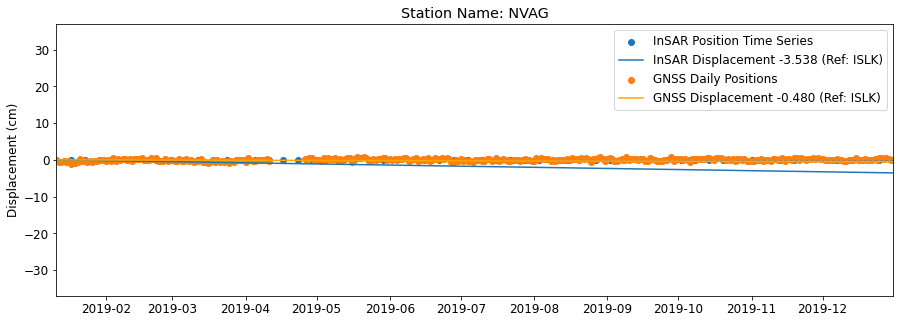

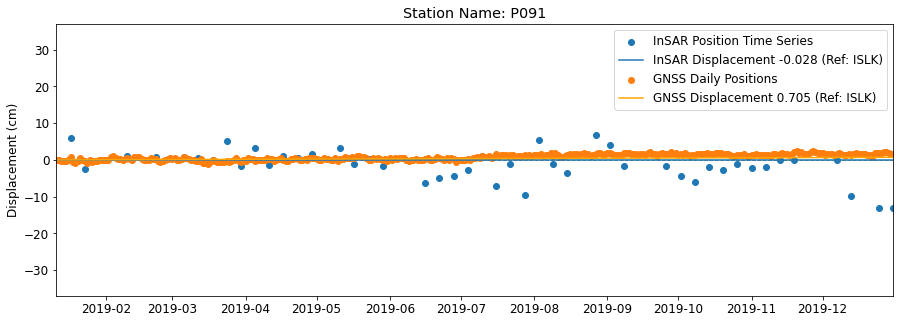

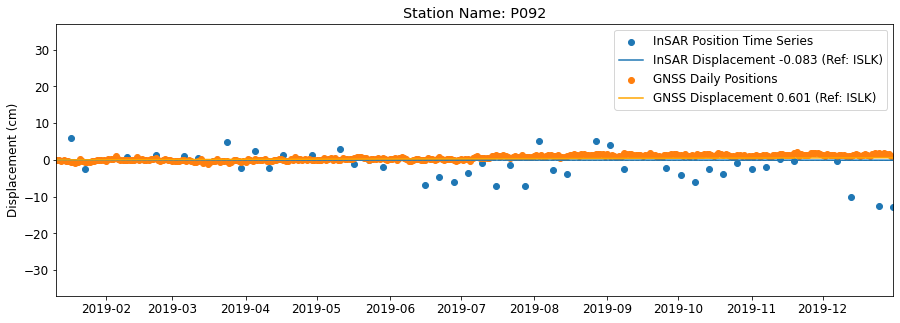

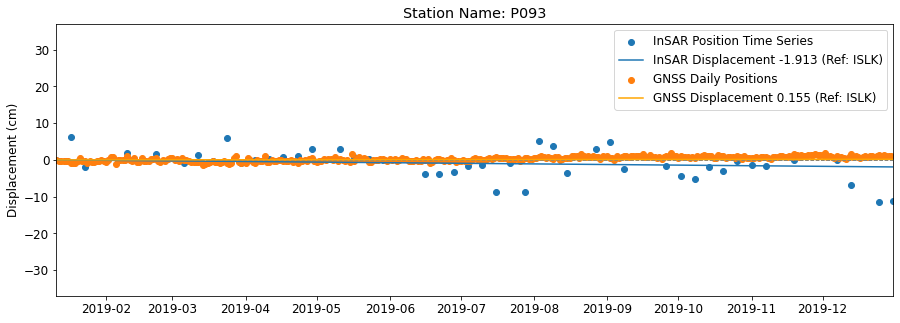

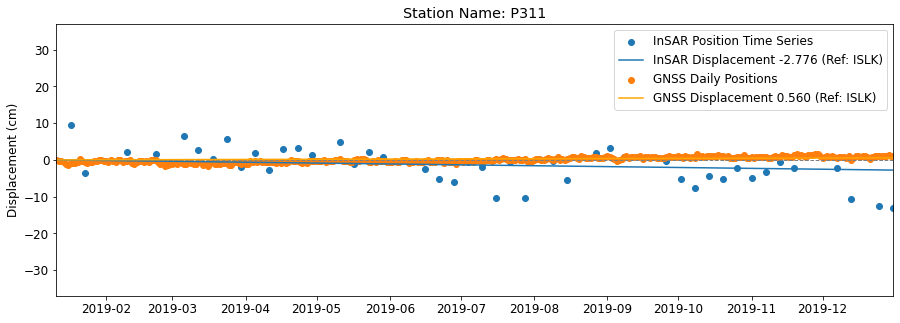

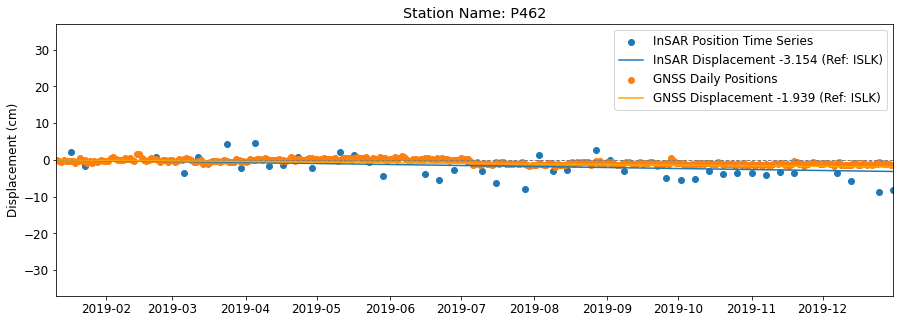

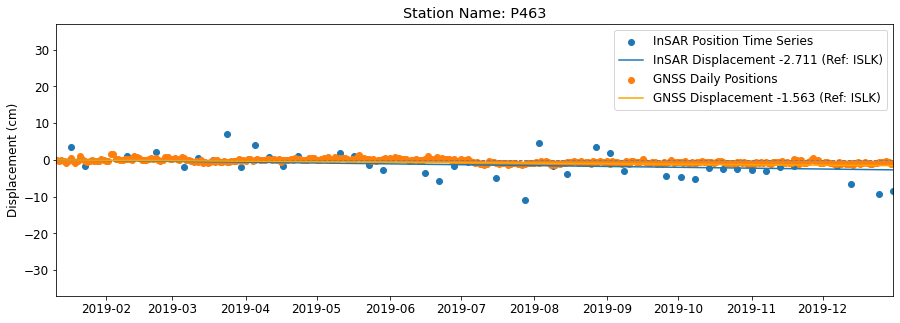

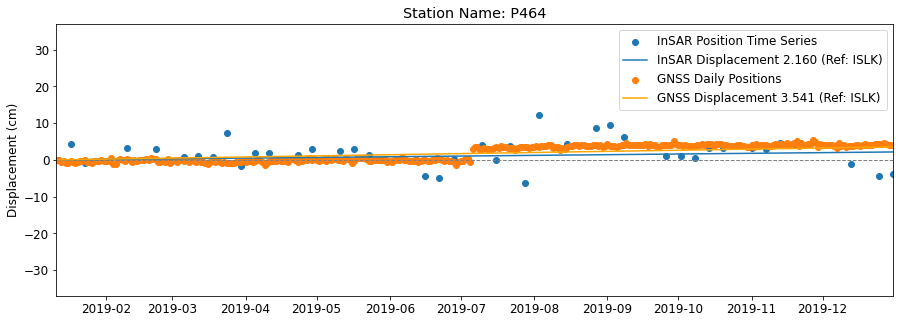

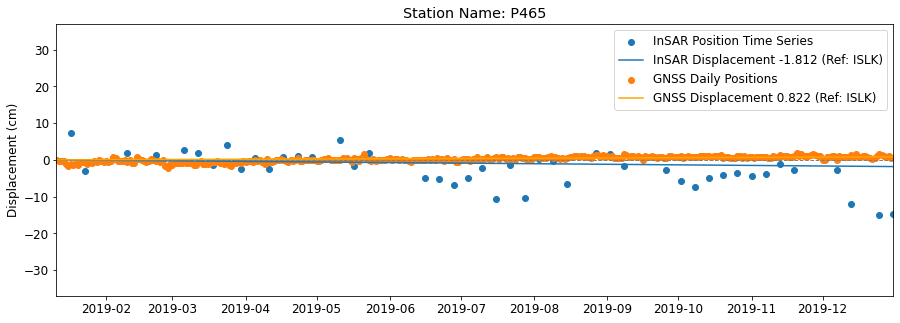

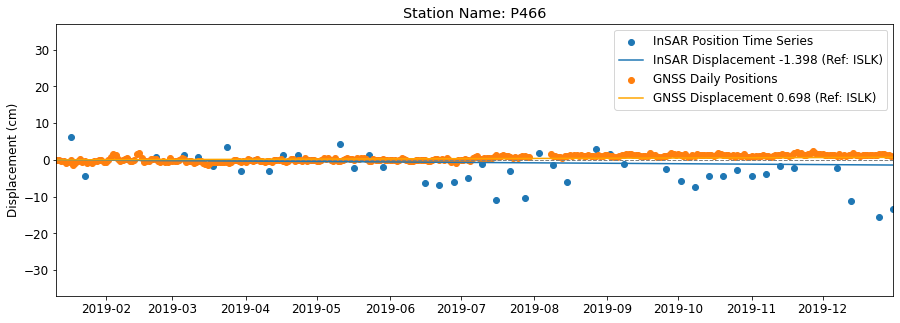

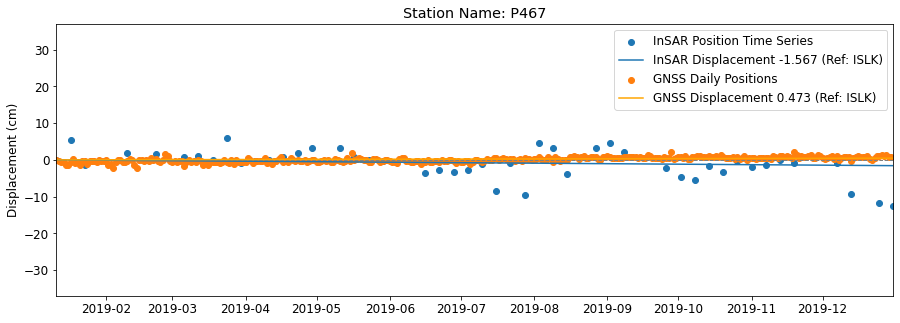

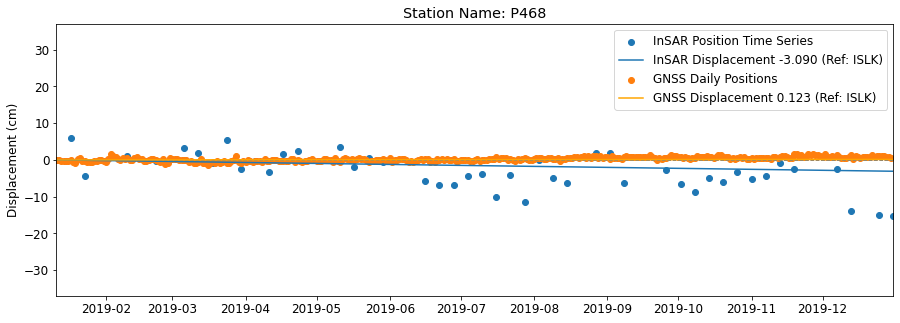

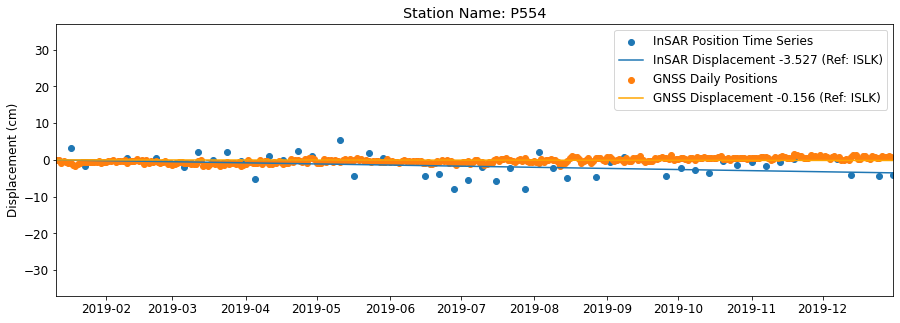

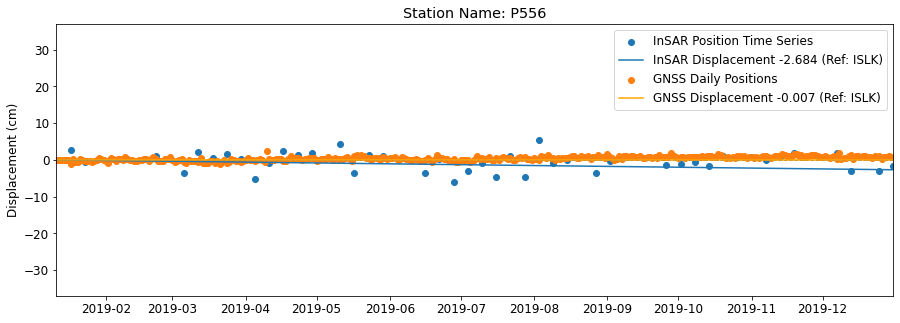

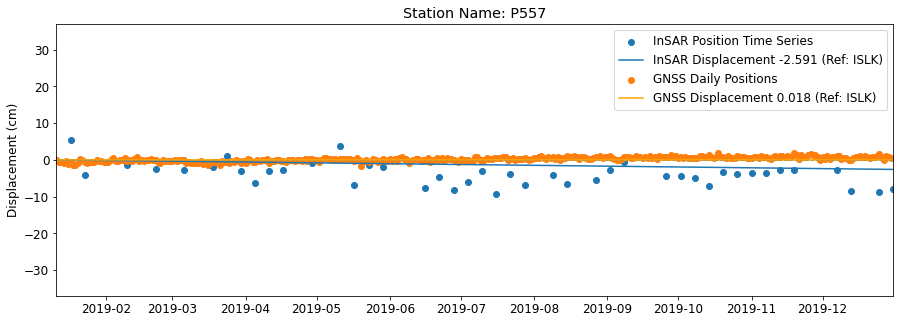

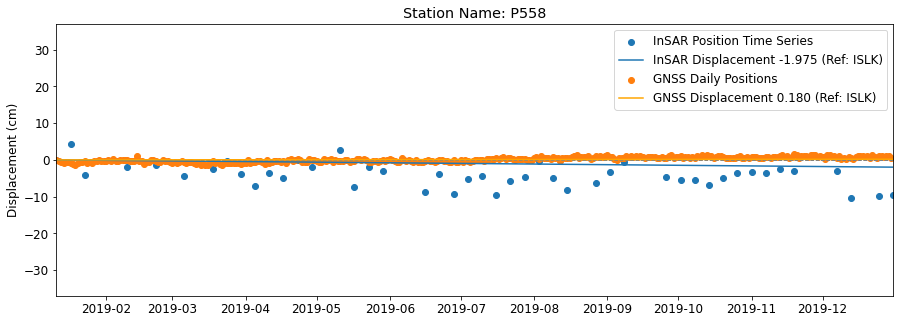

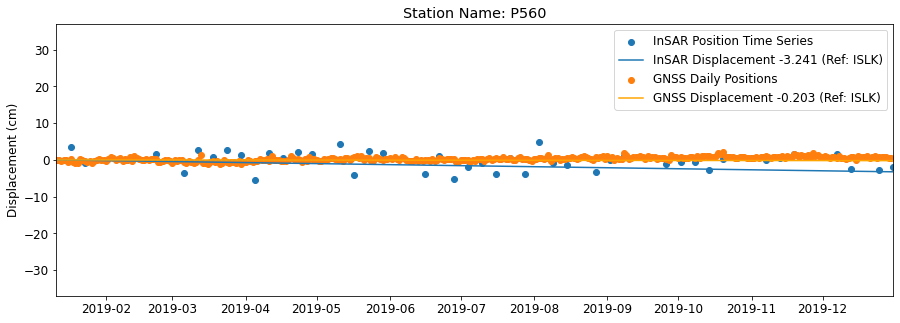

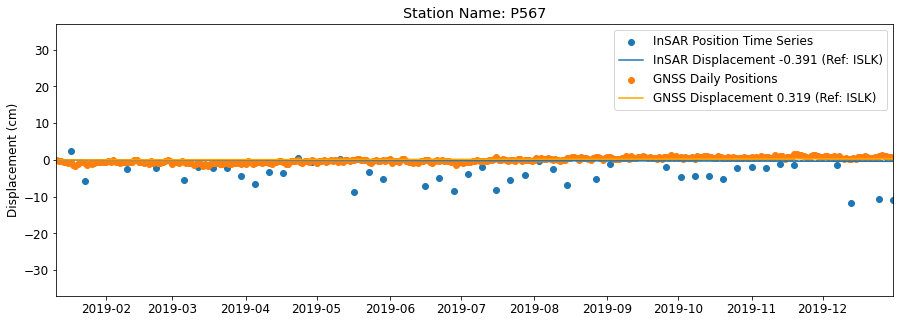

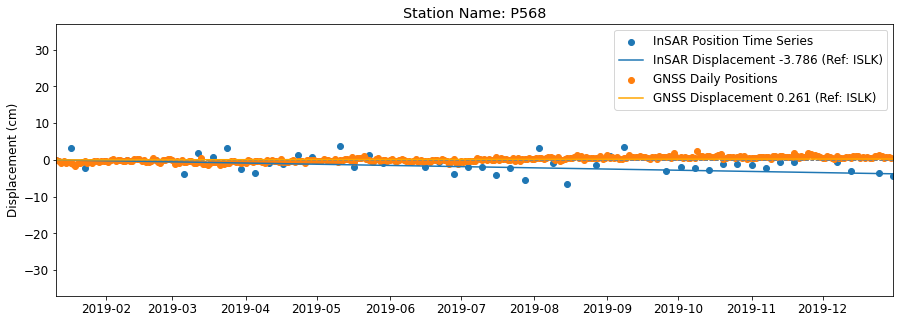

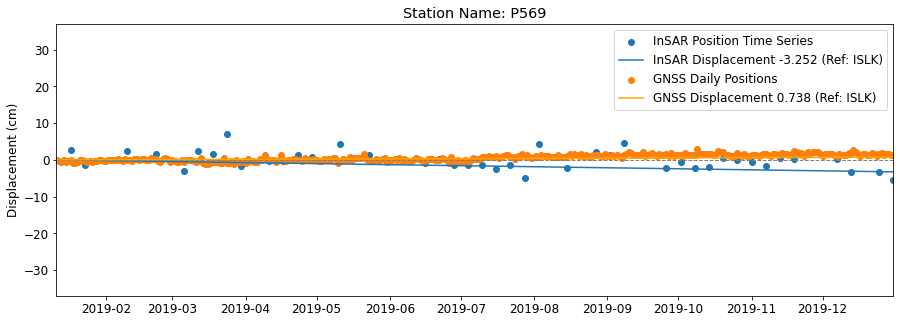

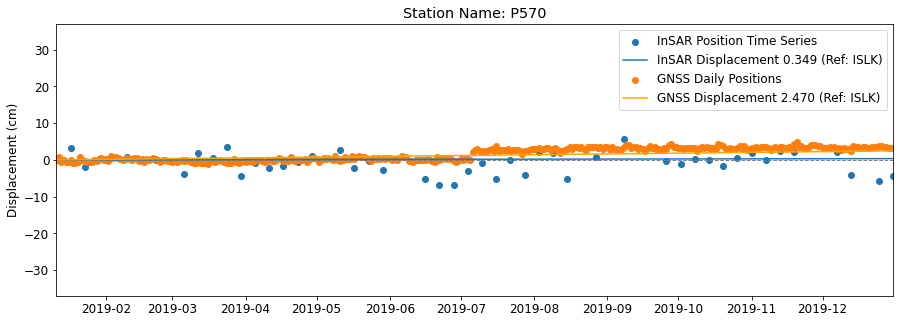

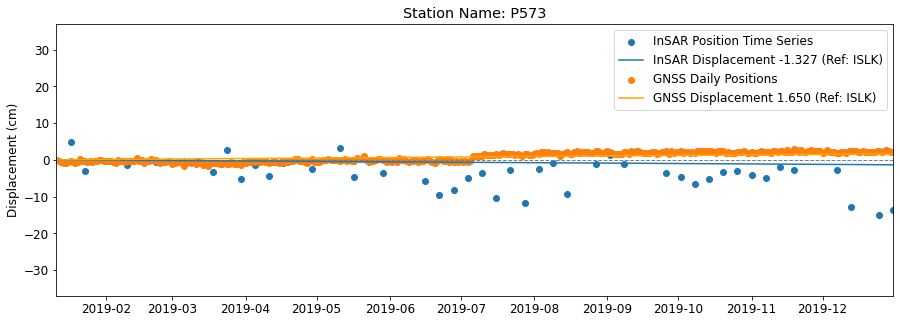

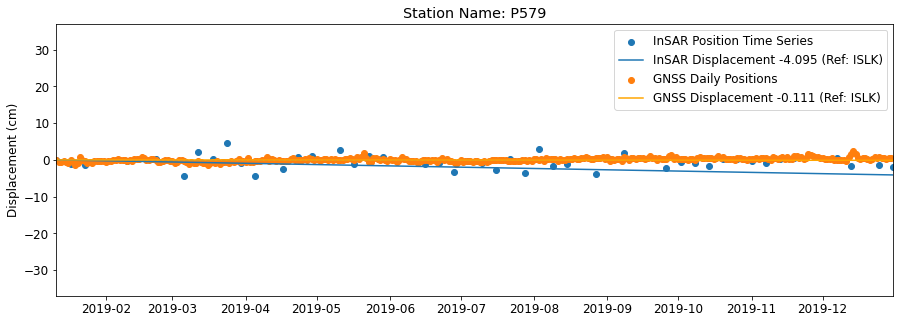

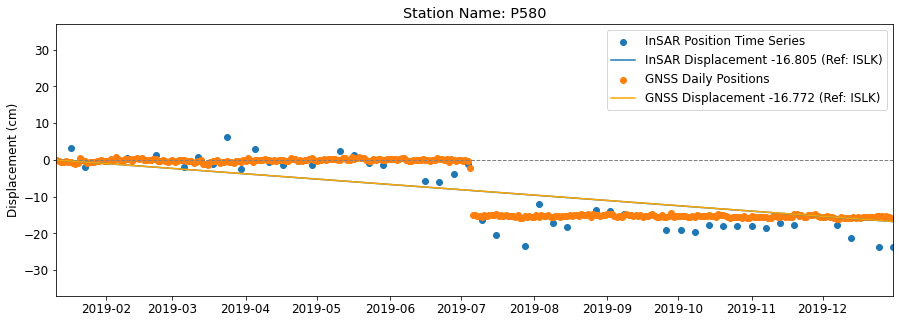

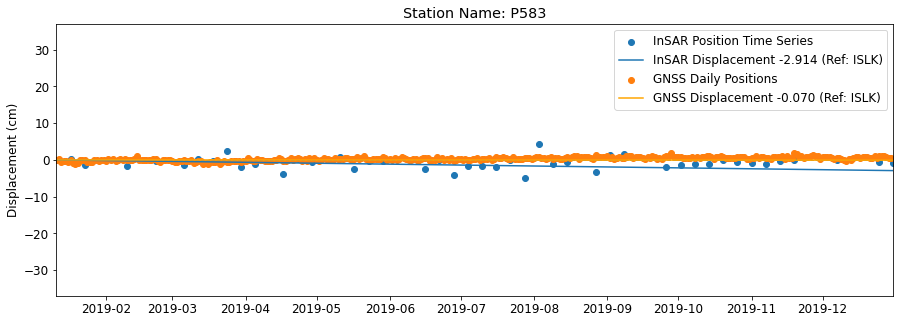

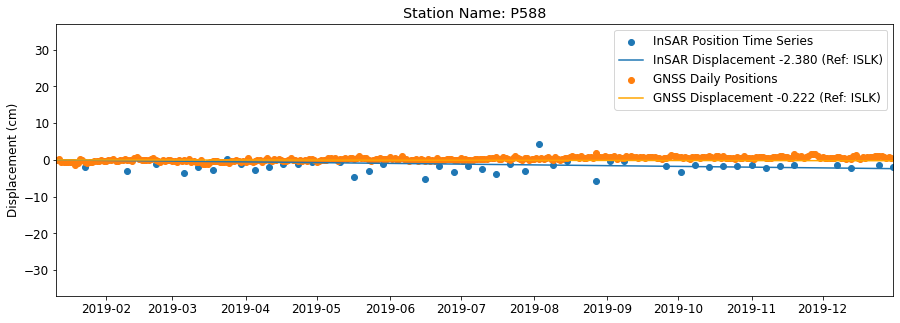

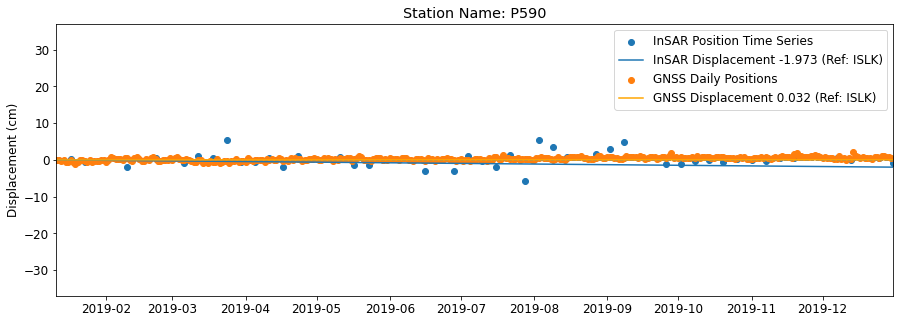

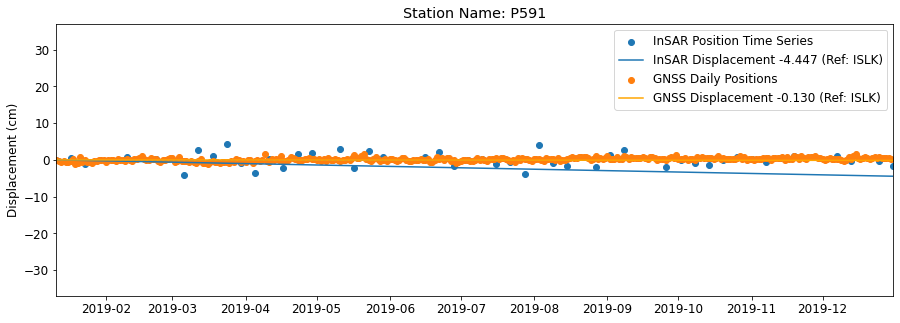

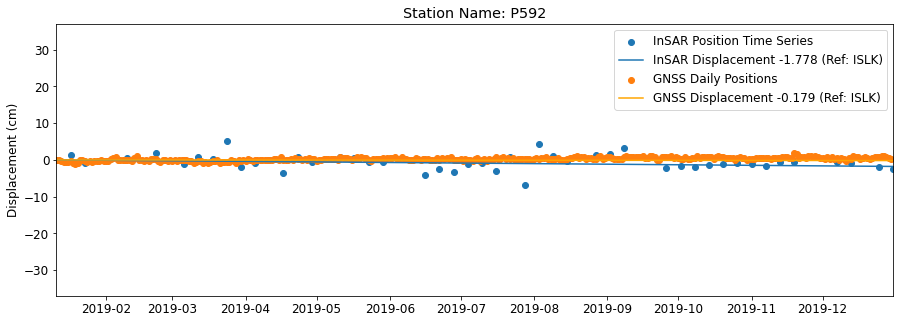

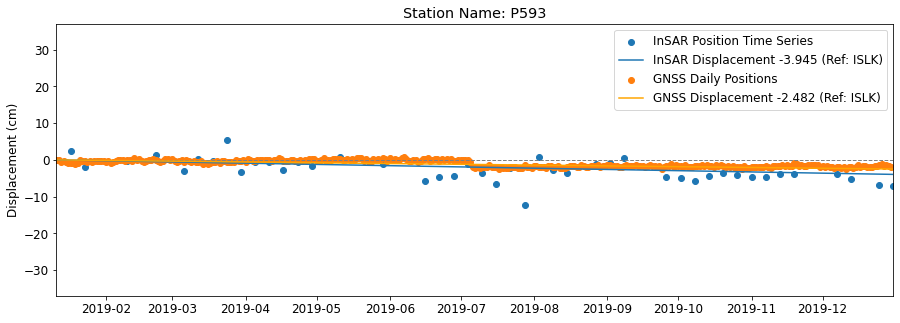

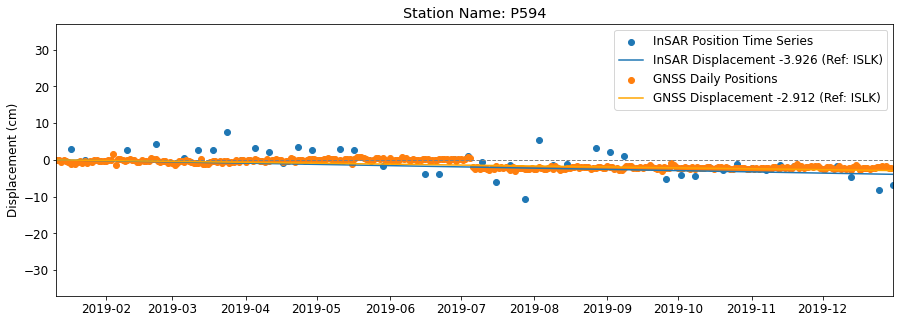

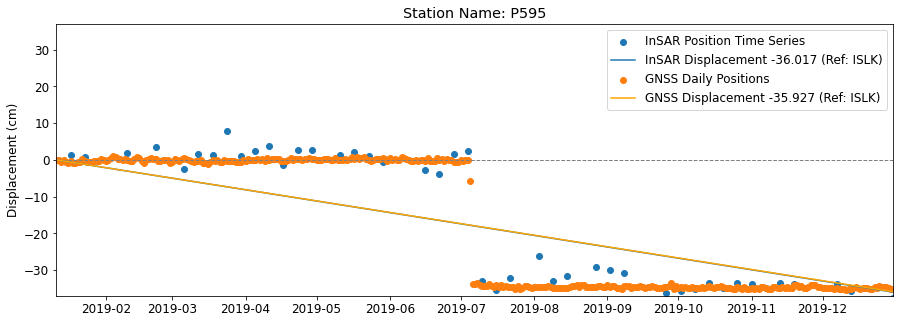

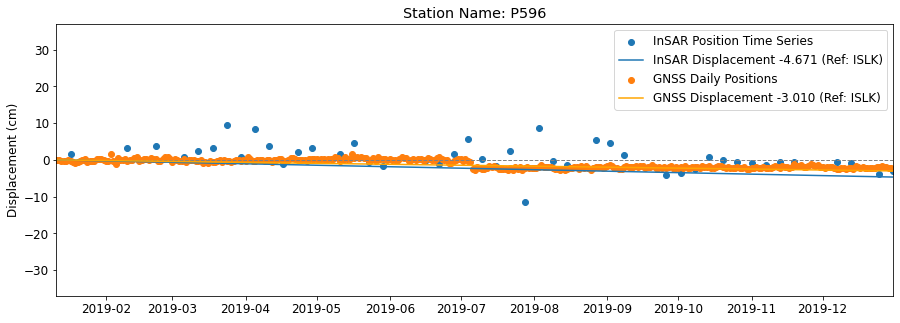

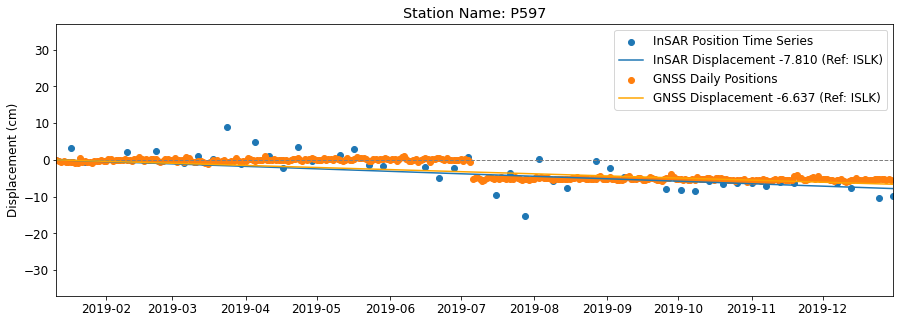

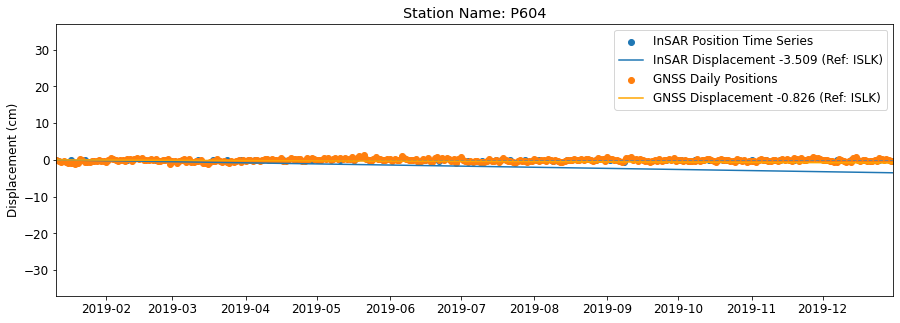

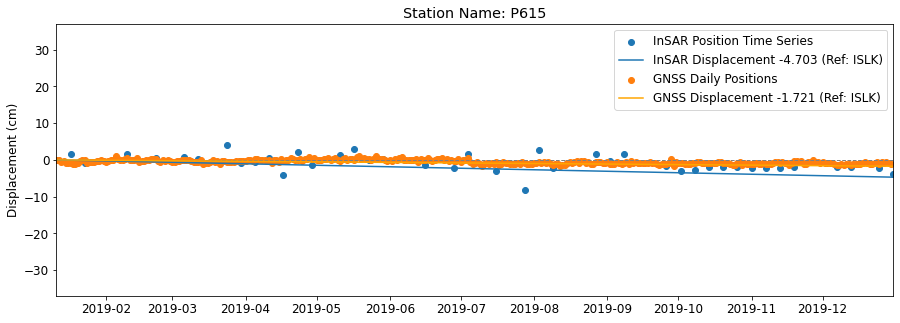

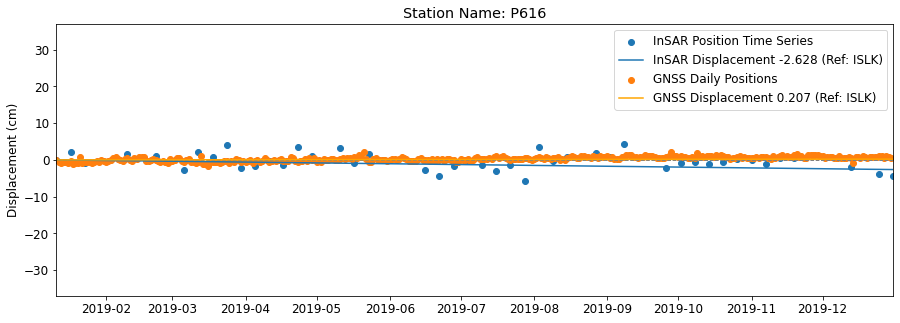

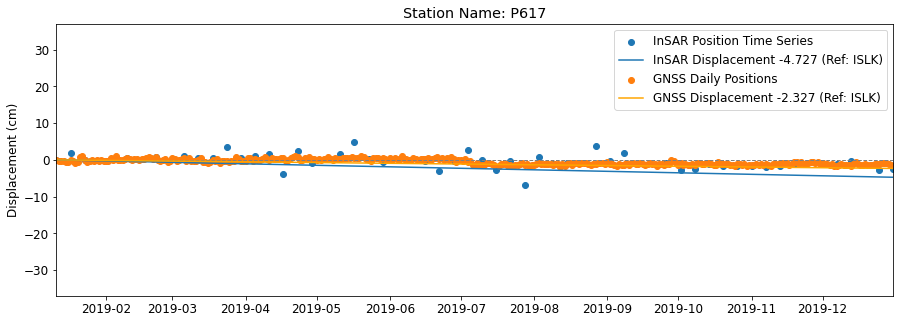

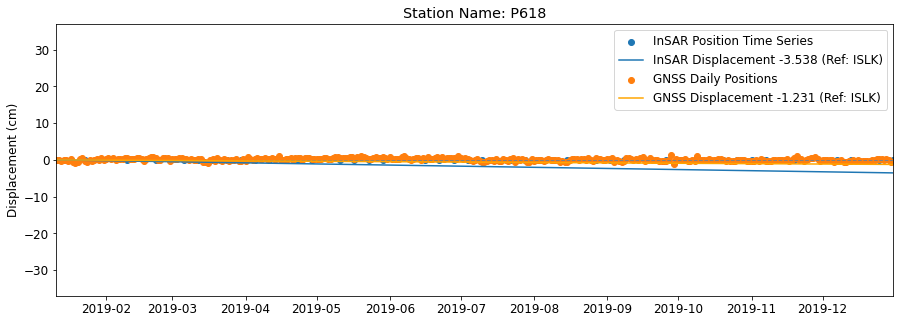

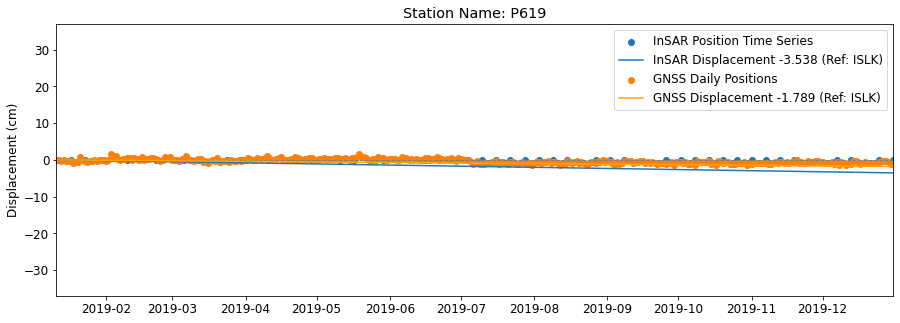

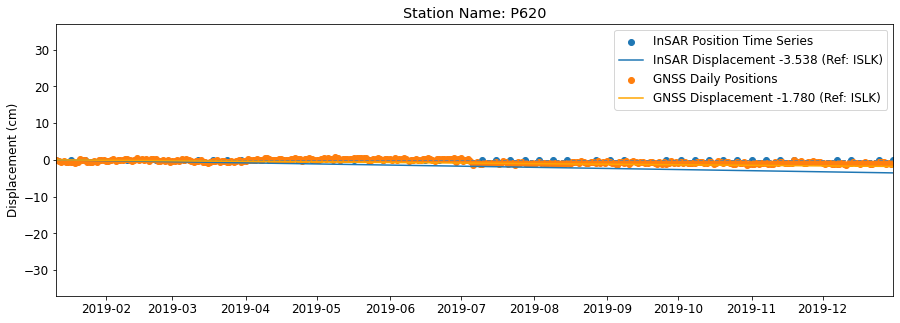

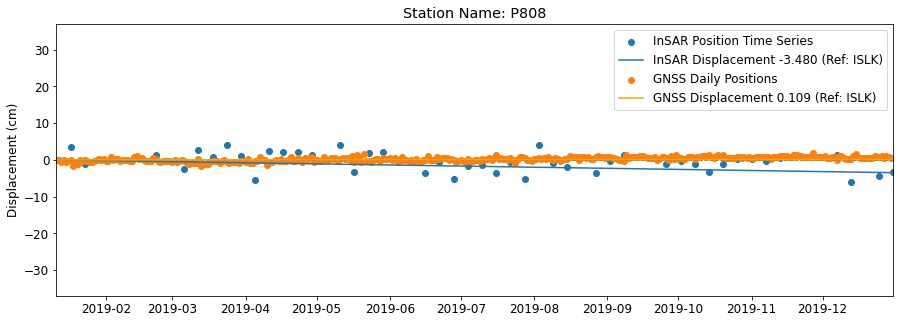

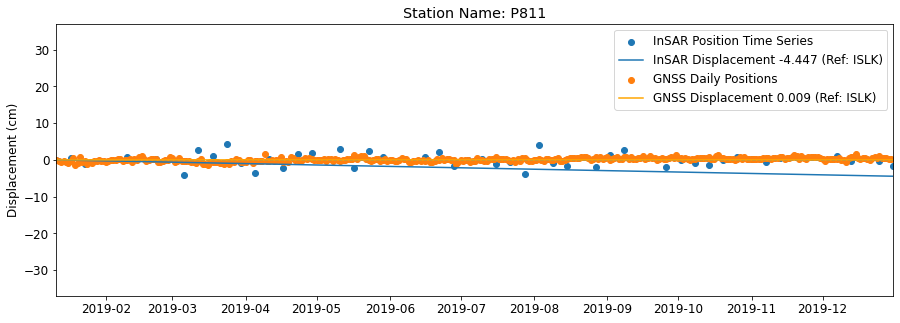

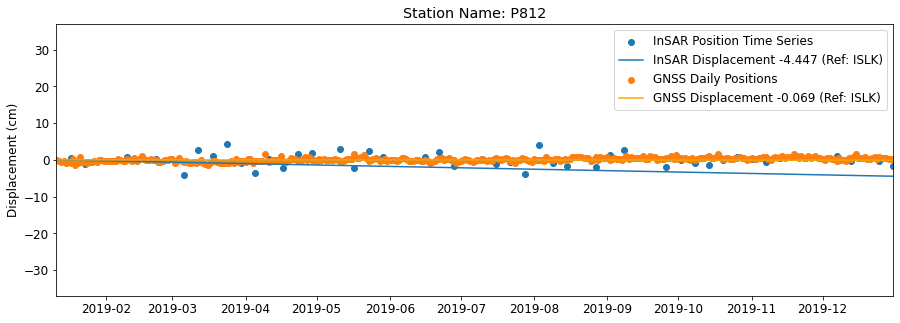

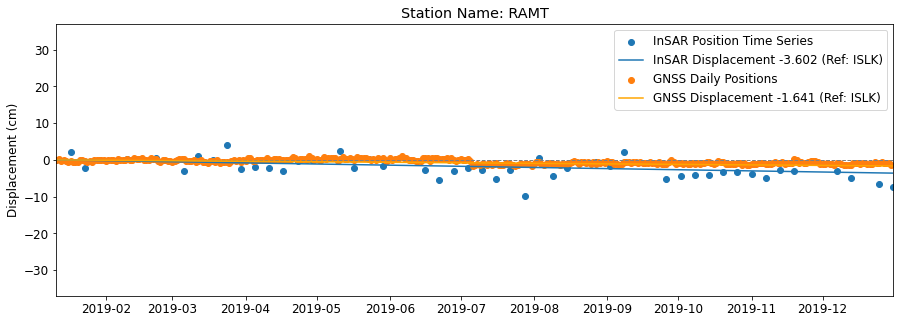

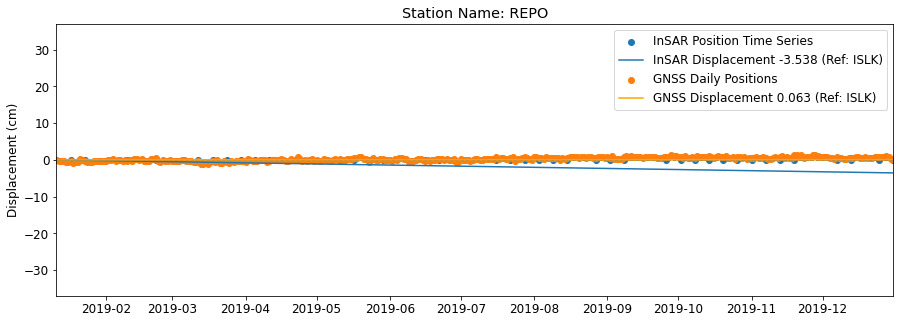

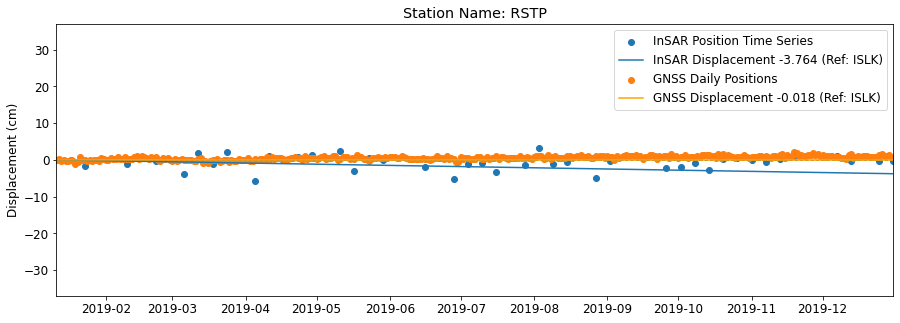

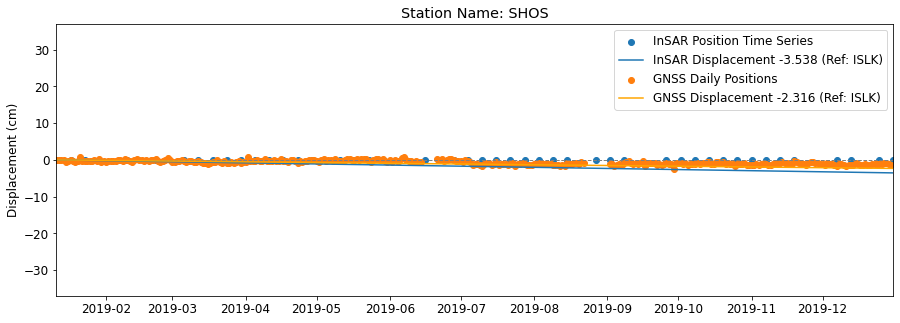

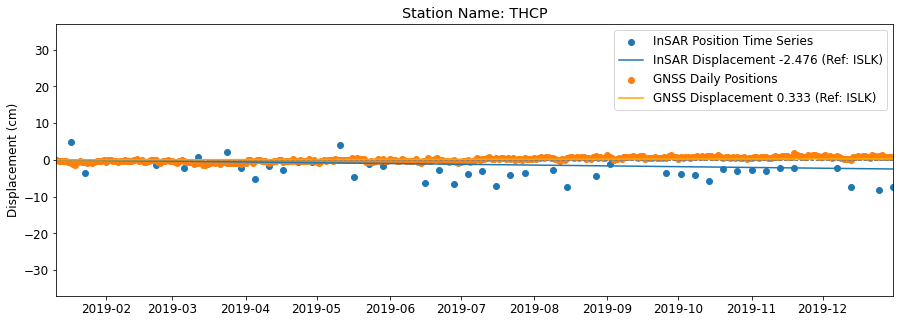

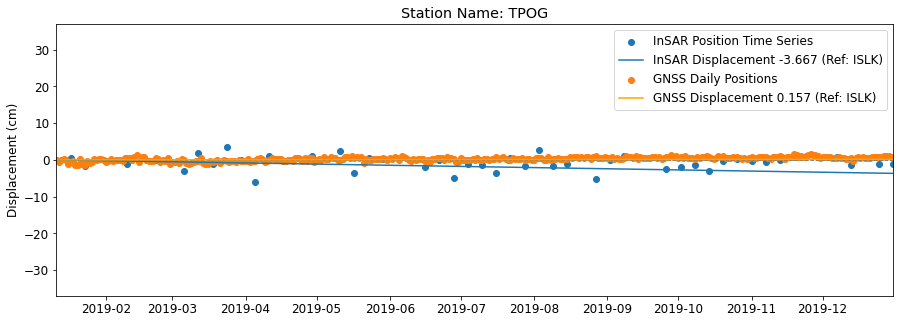

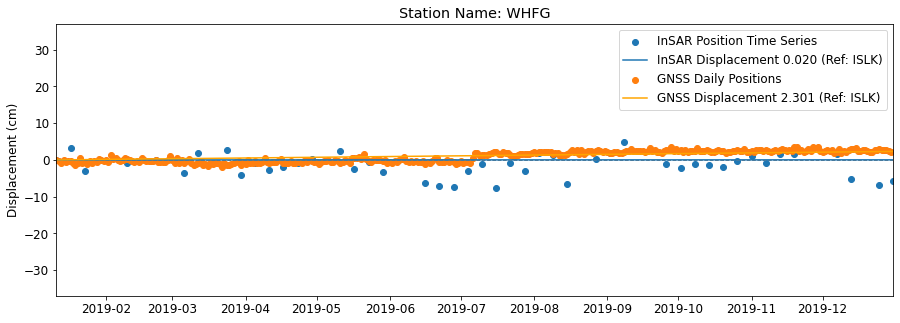

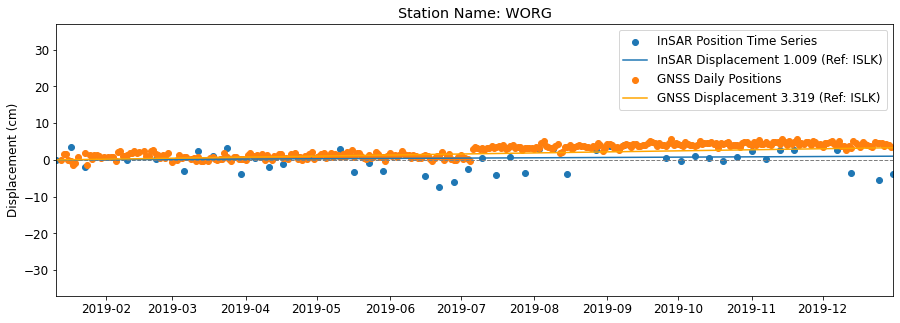

In [47]:
#Read in timeseries file
time_file = os.path.join(work_dir, 'MintPy/timeseries.h5')
insar_displacements = readfile.read(time_file, datasetName='timeseries')[0] * 100.

#Get aquisition dates, trim the str, and convert to datetime
raw_aqu_list = readfile.get_slice_list(time_file)
acquisitions_dates = []
for i in range(len(raw_aqu_list)):
    date = raw_aqu_list[i].split("-")
    #aqu_dates.append = date[1]
    acquisitions_dates.append(dt.strptime(date[1], "%Y%m%d"))
ndates = len(acquisitions_dates)

#Plot displacements and velocity timeseries at GNSS station locations
test_list = site_names
#test_list = ['P595'] #', 'CAHA', 'CAKC', 'CAND', 'CARH'] #for testing, remove after
for stn in test_list:
    
    #InSAR Info
    insar_timeseries = []
    stn_x = (stn_dict[stn][0])
    stn_y = (stn_dict[stn][1])
    for i in range(ndates):
        insar_displacement = insar_displacements[i,stn_y,stn_x]
        insar_timeseries.append(insar_displacement)     
    InSAR_stn_disp = stn_dict[stn][2]
    GNSS_stn_disp = stn_dict[stn][3]
    #print(InSAR_stn_vel)
    #print(GNSS_stn_vel)
    
    #get the length of time between first and last interferogram for velocity plotting
    insar_timespan = acquisitions_dates[ndates - 1] - acquisitions_dates[0]
    conversion = insar_timespan.days/365
    aqu_dates_convert=acquisitions_dates #/conversion
    
    #Plot InSAR
    plt.figure(figsize=(15,5))  
    plt.plot([0,100000],[0,0], color='grey',linestyle='dashed',linewidth=1)
    plt.scatter(acquisitions_dates, insar_timeseries, label="InSAR Position Time Series")
    #velocity trendline
    plt.plot([acquisitions_dates[0], acquisitions_dates[ndates - 1]],[0,InSAR_stn_disp],label=f"InSAR Displacement {InSAR_stn_disp:.3f} (Ref: {gps_ref_site_name})")

    #GNSS Info
    gps_obj = GPS(site = stn, data_dir = mint_dir + 'GPS')
    gps_obj.open()
    dates = gps_obj.dates
    # date range for this station
    statStart = gps_obj.date_list[0]
    statEnd = gps_obj.date_list[-1]

    dates, disp_los, std, site_lalo, ref_site_lalo = gps_obj.read_gps_los_displacement(geom_file, start_date=statStart, end_date=statEnd, ref_site=None,
                                  gps_comp=gps_comp, print_msg=False)
    
    #Plot GNSS
    index_begin = np.min(np.where(dates >= start_date_gnss))
    index_end = np.max(np.where(dates <= end_date_gnss))
    dates_cut = dates[index_begin:index_end]
    disp_los_cut = disp_los[index_begin:index_end]
    disp_los_cut = (disp_los_cut - np.median(disp_los_cut))*100
    plt.scatter(dates_cut, disp_los_cut - disp_los_cut[0], label="GNSS Daily Positions")   
    #velocity trendline
    plt.plot([acquisitions_dates[0], acquisitions_dates[ndates - 1]],[0,GNSS_stn_disp],color='orange',label=f"GNSS Displacement {GNSS_stn_disp:.3f} (Ref: {gps_ref_site_name})")

    plt.title(f"Station Name: {stn}") 
    plt.ylabel('Displacement (cm)')
    plt.ylim(-37,37) # plot range for Ridgecrest
    plt.xlim(aqu_dates_convert[0],aqu_dates_convert[ndates - 1])
    plt.legend(loc="best")
    

In [ ]:
print((insar_timeseries))